# Información previa

## Diseño y esquema codigo

Predicción de prophet de la demanda y el precio


1. Predecir **Demanda** al corto plazo

2. Predecir el **Precio** promedio ponderado `Ventas CLP.sum()/Demanda KG.sum()`

* Predecir al corto plazo, generando un resultado del error al predecir el año 2021, semana a semana.


        

## Este es un extracto del paper:
 

	
Ventas pasadas con retraso  k, es decir, ventas diarias para el SKU considerado de los últimos k días (tw k : ventana de tiempo de tamaño k ).

	
* Variables binarias para caracterizar días especiales, como:
    * Pago , que caracteriza los días al final de cada mes cuando las personas reciben el pago mensual.
    * Pago intermedio , que caracteriza los días al final de cada quincena en que las personas reciben dos pagos semanales.
    * Antes de las vacaciones , caracterizando los días antes de las vacaciones.
    * Vacaciones , que caracterizan las vacaciones.
    * Independencia , que caracteriza los días de la independencia de Chile (18 y 19 de septiembre).
    * Santa , caracterizando los días de la semana antes del este.
    * Vacaciones , caracterizando los días que pertenecen al período de vacaciones de verano (enero y febrero).
    * Verano , que caracteriza los días de verano (1 de octubre-31 de marzo).	
    * Año nuevo (1 de enero), que caracteriza el único día de cierre de supermercados en Chile.
	
	
* Variables de precio:
    * Precio A  =  precio original del SKU considerado en Economax.
    * Precio B  =  (Precio A) / (Precio máximo en micro-mercado).
    * Precio C  =  (Precio A) / (Precio mínimo en micro-mercado).

		
Observación : Las variables “Precio máximo en micro-mercado” y “Precio mínimo en micro-mercado” son el precio máximo (mínimo) para un determinado SKU en el micro-mercado relevante y son proporcionados por una empresa de investigación de mercado.
		
	

	
 

# Package Install & Open Data


## Import

### Función de ajuste de zona 

In [1]:
def Df_ubic(data_X,col,Str):
    df=data_X.copy()
    df=df[df[col]==Str]
    return df

### import general 

In [2]:
# =============================================================================
# Importar paquetes y abrir Data
# =============================================================================

#gestion DF
import pandas as pd

#Funciones mat y matricicales
import numpy as np

#ploteo simple
import matplotlib.pyplot as plt

# Graficas bonitas
from plotnine import *

#para ajustar las fechas
import datetime

#para calcular el skew de un array() o list()
from scipy.stats import skew 

#mode function
import statistics 

from mizani.breaks import date_breaks
from mizani.formatters import date_format

### import and function 

In [3]:

import warnings
import pandas as pd
import matplotlib.pyplot as plt
# prophet model 
from fbprophet import Prophet
# prophet preformance
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

# don't do this 
warnings.filterwarnings('ignore')
# "high resolution"
%config InlineBackend.figure_format = 'retina'

Importing plotly failed. Interactive plots will not work.


##  Data Facturación CT(New)
Esta data contiene las facturaciones(Ventas a los clientes del canal tradicional)

### Selección de la zona de estudio 

In [4]:
#Nombre del producto
SKU='1020003'

# =============================================================================
# Ajuste de los datos
# =============================================================================
File_name='Facturación CT '+SKU
col_names=pd.read_csv("Data/\last_down/"+File_name+".csv",
                    encoding="utf-8",sep=";",nrows=0).columns
types_dict = {col: str for col in col_names}

Data = pd.read_csv("Data/(column)Facturac_2017_2020.csv",
                   encoding="utf-8",sep=";",dtype=types_dict)
Data.head(1)

,Material,Tipo de cliente,Zona de ventas,Zona de ventas.1,Oficina de Ventas Unifica,Oficina de Ventas Unifica.1,Zona de reparto,Subtipo de cliente,Cluster,Cliente - Local,Cliente - Local.1,Mes,Año natural/Semana,Día natural,Día de la semana,Kilos Venta KG,Venta Neta CLP,Precio Promedio CLP
0,1020003,Tradicional,Z001,Santiago,Huechuraba,T101,113101019,Espec. en Crudos,Clásico,Alarcon Basabe Horacio Jesus,3200138357,9,39.2019,26.09.2019,JU,41,105.664,2.6


In [5]:
Data=Df_ubic(Data,'Oficina de Ventas Unifica','Temuco')

### Ajuste facturaciones

In [6]:
# =============================================================================
# Ajustar la data
# =============================================================================
def Ajuste_data(data):
    df=data.copy()
    # Funciones para eliminar los putos y cambiar las , por .
    def change_num_point(x):
        x=str(x)
        return x.replace('.', '')
    def change_num_coma(x):
        x=str(x)
        return x.replace(',', '.')
    
    #proceso iterativo, 
    for i in ['Kilos Venta KG','Venta Neta CLP','Precio Promedio CLP']:
    # se elimina el punto definido para los miles
        df[i]=df[i].apply(change_num_point)
        # se reemplaza la coma por un punto, para definir los decimales correctamente
        df[i]=df[i].apply(change_num_coma)
        # Se pasa de ser un str a un int
        df[i]=df[i].astype('int64')

    #Separacion fecha
    df['Semana']=df['Año natural/Semana'].str.split('.', expand=True)[[0]]
    df['Año']=df['Año natural/Semana'].str.split('.', expand=True)[[1]]

    df['Semana']=df['Semana'].astype('int64')
    df['Año']=df['Año'].astype('int64')
    
    #
    df["Día natural"] = df["Día natural"].apply(lambda x: 
                                                datetime.datetime.strptime(x,
                                                                           '%d.%m.%Y').date())
    return df

In [7]:
data=Ajuste_data(Data)
data.head(3)
#data=<data[data['Año']>2018]

,Material,Tipo de cliente,Zona de ventas,Zona de ventas.1,Oficina de Ventas Unifica,Oficina de Ventas Unifica.1,Zona de reparto,Subtipo de cliente,Cluster,Cliente - Local,Cliente - Local.1,Mes,Año natural/Semana,Día natural,Día de la semana,Kilos Venta KG,Venta Neta CLP,Precio Promedio CLP,Semana,Año
75186,1020003,Tradicional,Z004,Sur,Temuco,T105,8000480112,Espec. en Crudos,Sin asignar,Castro Muñoz Jose Isaias,3200104287,4,15.2021,2021-04-12,LU,43,182668,429,15,2021
75187,1020003,Tradicional,Z004,Sur,Temuco,T105,8000480112,Espec. en Crudos,Sin asignar,Castro Muñoz Jose Isaias,3200104287,4,16.2021,2021-04-21,MI,43,157268,369,16,2021
75188,1020003,Tradicional,Z004,Sur,Temuco,T105,8000480112,Espec. en Crudos,Sin asignar,Castro Muñoz Jose Isaias,3200104287,4,17.2021,2021-04-26,LU,20,69393,339,17,2021


##  Data Clientes
Esta data posee las caracteristicas de los clientes del canal tradicional

In [8]:
Cluster = pd.read_csv("Data/Cluster_clientes.csv",
                          encoding="utf-8",sep=";",dtype={'Cliente - Local.1': 'str'})

### Incluir Columna Cluster(Segmento de cliente)

In [9]:
DF_ventas=pd.merge(Cluster[['Cliente - Local.1','identified_clusters']] , data  
     , how='right')

In [10]:
DF_ventas.sort_values(by='Día natural').tail(3)


,Cliente - Local.1,identified_clusters,Material,Tipo de cliente,Zona de ventas,Zona de ventas.1,Oficina de Ventas Unifica,Oficina de Ventas Unifica.1,Zona de reparto,Subtipo de cliente,...,Cliente - Local,Mes,Año natural/Semana,Día natural,Día de la semana,Kilos Venta KG,Venta Neta CLP,Precio Promedio CLP,Semana,Año
280,3200102010,1.0,1020003,Tradicional,Z004,Sur,Temuco,T105,8000580011,Espec. en Procesados,...,Forcael Beltran Jerry Luis,5,20.2021,2021-05-20,JU,82,381203,4633,20,2021
3465,58651,0.0,1020003,Tradicional,Z004,Sur,Temuco,T105,8000580087,Espec. en Crudos,...,Los Camperos Temuco,5,20.2021,2021-05-20,JU,40,195258,489,20,2021
1542,33511,0.0,1020003,Tradicional,Z004,Sur,Temuco,T105,8000580038,Multiespecialista,...,Fernandez Villanueva Maximiliano,5,20.2021,2021-05-20,JU,21,102750,50,20,2021


## Data Stock
Esta data posee el nivel de stock de las sucursales de la zona de santiago

In [11]:
fillN='Stock CL '+SKU
col_names=pd.read_csv("Data/last_down/"+fillN+".csv",
                    encoding="utf-8",sep=";",nrows=0).columns
types_dict = {col: str for col in col_names}

Data_stock = pd.read_csv("Data/last_down/"+fillN+".csv",
                   encoding="utf-8",sep=";",dtype=types_dict)
print(Data_stock.shape)

(9938, 9)


In [12]:
Data_stock.head(1)

,Sector,Material,Zona de ventas,Oficina de ventas,Oficina de ventas.1,Año natural/Semana,Día natural,Vida Útil Restante,Stock
0,Cerdo,1020003,Sur,T019,Punta Arenas,01.2020,30.12.2019,8,"111,8"


In [13]:
Data_stock=Df_ubic(Data_stock,'Oficina de ventas.1','Temuco')

In [14]:
Data_stock.head()

,Sector,Material,Zona de ventas,Oficina de ventas,Oficina de ventas.1,Año natural/Semana,Día natural,Vida Útil Restante,Stock
193,Cerdo,1020003,Sur,T105,Temuco,15.2021,12.04.2021,8,"2.119,1"
194,Cerdo,1020003,Sur,T105,Temuco,15.2021,13.04.2021,7,"2.362,0"
195,Cerdo,1020003,Sur,T105,Temuco,15.2021,14.04.2021,7,"2.671,1"
196,Cerdo,1020003,Sur,T105,Temuco,15.2021,15.04.2021,7,"3.142,4"
197,Cerdo,1020003,Sur,T105,Temuco,15.2021,16.04.2021,7,"2.187,1"


In [15]:
# =============================================================================
# Ajustar la data
# =============================================================================
def Ajuste_data(data):
    df=data.copy()
    # Funciones para eliminar los putos y cambiar las , por .
    def change_num_point(x):
        x=str(x)
        return x.replace('.', '')
    def change_num_coma(x):
        x=str(x)
        return x.replace(',', '.')
    
    #proceso iterativo, 
    for i in ['Stock']:
    # se elimina el punto definido para los miles
        df[i]=df[i].apply(change_num_point)
        # se reemplaza la coma por un punto, para definir los decimales correctamente
        df[i]=df[i].apply(change_num_coma)
        # Se pasa de ser un str a un int
        #df[i]=df[i].astype('int64')
        df[i]=df[i].astype('float64')

    #Separacion fecha
    df['Semana']=df['Año natural/Semana'].str.split('.', expand=True)[[0]]
    df['Año']=df['Año natural/Semana'].str.split('.', expand=True)[[1]]

    df['Semana']=df['Semana'].astype('int64')
    df['Año']=df['Año'].astype('int64')
    
    #
    df["Día natural"] = df["Día natural"].apply(lambda x: 
                                                datetime.datetime.strptime(x,
                                                                           '%d.%m.%Y').date())
    df['Vida Útil Restante']=df['Vida Útil Restante'].astype('int64')
    return df

In [16]:
Data_stock=Ajuste_data(Data_stock)

In [17]:
Data_stock.tail()

,Sector,Material,Zona de ventas,Oficina de ventas,Oficina de ventas.1,Año natural/Semana,Día natural,Vida Útil Restante,Stock,Semana,Año
9686,Cerdo,1020003,Sur,T005,Temuco,51.2019,2019-12-17,-138,0.0,51,2019
9687,Cerdo,1020003,Sur,T005,Temuco,51.2019,2019-12-18,-140,0.0,51,2019
9688,Cerdo,1020003,Sur,T005,Temuco,51.2019,2019-12-19,-142,0.0,51,2019
9689,Cerdo,1020003,Sur,T005,Temuco,51.2019,2019-12-20,-144,0.0,51,2019
9690,Cerdo,1020003,Sur,T005,Temuco,51.2019,2019-12-21,-146,0.0,51,2019


## Demanda Zona
Data_totales posee el DF de todas las ventas de 

In [18]:
fillN='Vetas Totales CL '+SKU
col_names=pd.read_csv("Data/last_down/"+fillN+".csv",
                    encoding="utf-8",sep=";",nrows=0).columns
types_dict = {col: str for col in col_names}

Data_totales = pd.read_csv("Data/last_down/"+fillN+".csv",
                   encoding="utf-8",sep=";",dtype=types_dict)
Data_totales.head(2)

,Material,Tipo de cliente,Zona de ventas,Zona de ventas.1,Oficina de Ventas Unifica,Oficina de Ventas Unifica.1,Zona de reparto,Subtipo de cliente,Cluster,Cliente - Local,Cliente - Local.1,Mes,Año natural/Semana,Día natural,Día de la semana,Kilos Venta KG,Venta Neta,Precio Promedio
0,1020003,Tradicional,Z001,Santiago,Huechuraba,T101,113101019,Espec. en Crudos,Clásico,Alarcon Basabe Horacio Jesus,3200138357,9,39.2019,26.09.2019,JU,41,105.664,2.600
1,1020003,Tradicional,Z001,Santiago,Huechuraba,T101,113101019,Espec. en Crudos,Clásico,Nawrath Maira Maria Evangelina,25800,5,19.2019,09.05.2019,JU,20,65.934,3.300


In [19]:
#Data_totales=
Data_totales=Df_ubic(Data_totales,'Oficina de Ventas Unifica','Temuco')
Data_totales.head()

,Material,Tipo de cliente,Zona de ventas,Zona de ventas.1,Oficina de Ventas Unifica,Oficina de Ventas Unifica.1,Zona de reparto,Subtipo de cliente,Cluster,Cliente - Local,Cliente - Local.1,Mes,Año natural/Semana,Día natural,Día de la semana,Kilos Venta KG,Venta Neta,Precio Promedio
75186,1020003,Tradicional,Z004,Sur,Temuco,T105,8000480112,Espec. en Crudos,Sin asignar,Castro Muñoz Jose Isaias,3200104287,4,15.2021,12.04.2021,LU,43,182.668,4.290
75187,1020003,Tradicional,Z004,Sur,Temuco,T105,8000480112,Espec. en Crudos,Sin asignar,Castro Muñoz Jose Isaias,3200104287,4,16.2021,21.04.2021,MI,43,157.268,3.690
75188,1020003,Tradicional,Z004,Sur,Temuco,T105,8000480112,Espec. en Crudos,Sin asignar,Castro Muñoz Jose Isaias,3200104287,4,17.2021,26.04.2021,LU,20,69.393,3.390
75189,1020003,Tradicional,Z004,Sur,Temuco,T105,8000480112,Espec. en Crudos,Sin asignar,Castro Muñoz Jose Isaias,3200104287,5,18.2021,05.05.2021,MI,26,94.489,3.590
75190,1020003,Tradicional,Z004,Sur,Temuco,T105,8000480112,Espec. en Crudos,Sin asignar,Castro Muñoz Jose Isaias,3200104287,5,19.2021,10.05.2021,LU,37,141.412,3.849


### Ajuste data 

Se identifico el problema

In [20]:
# =============================================================================
# Ajustar la data
# =============================================================================
def Ajuste_data(data):
    df=data.copy()
    # Funciones para eliminar los putos y cambiar las , por .
    def change_num_point(x):
        x=str(x)
        return x.replace('.', '')
    def change_num_coma(x):
        x=str(x)
        return x.replace(',', '.')
    
    #proceso iterativo, 
    for i in ['Kilos Venta KG','Venta Neta','Precio Promedio']:
    # se elimina el punto definido para los miles
        df[i]=df[i].apply(change_num_point)
        # se reemplaza la coma por un punto, para definir los decimales correctamente
        df[i]=df[i].apply(change_num_coma)
        # Se pasa de ser un str a un int
        df[i]=df[i].astype('int64')

    #Separacion fecha
    df['Semana']=df['Año natural/Semana'].str.split('.', expand=True)[[0]]
    df['Año']=df['Año natural/Semana'].str.split('.', expand=True)[[1]]

    df['Semana']=df['Semana'].astype('int64')
    df['Año']=df['Año'].astype('int64')
    
    #
    df["Día natural"] = df["Día natural"].apply(lambda x: 
                                                datetime.datetime.strptime(x,
                                                                           '%d.%m.%Y').date())
    return df

In [21]:
#Data_totales=
Ajuste_data(Data_totales).head(2)
Data_totales=Ajuste_data(Data_totales)

###  Calclulo consumo dia

In [22]:
Data_totales.describe(include='all')

,Material,Tipo de cliente,Zona de ventas,Zona de ventas.1,Oficina de Ventas Unifica,Oficina de Ventas Unifica.1,Zona de reparto,Subtipo de cliente,Cluster,Cliente - Local,Cliente - Local.1,Mes,Año natural/Semana,Día natural,Día de la semana,Kilos Venta KG,Venta Neta,Precio Promedio,Semana,Año
count,11243,11243,11243,11243,11243,11243,11243,11243,11243,11243,11243,11243,11243,11243,11243,11243.000000,1.124300e+04,11243.000000,11243.000000,11243.000000
unique,1,5,1,1,1,1,100,24,3,572,584,12,228,1281,6,NaN,NaN,NaN,NaN,NaN
top,1020003,Supermercados,Z004,Sur,Temuco,T105,8000580079,Potencial,Sin asignar,Eltit San Luis,3200048452,2,08.2020,2019-11-28,VI,NaN,NaN,NaN,NaN,NaN
freq,11243,6290,11243,11243,11243,11243,1331,5252,7762,520,520,1458,118,40,2502,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.053811,1.353303e+05,3370.278307,23.458241,2018.816953
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.463691,1.799665e+05,902.582079,15.117788,1.307175
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.000000,1.272000e+04,690.000000,1.000000,2017.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.000000,6.331500e+04,2900.000000,10.000000,2018.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.000000,8.547000e+04,3200.000000,21.000000,2019.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.000000,1.438500e+05,3550.000000,36.000000,2020.000000


In [23]:
Data_totales_S=Data_totales.groupby(['Tipo de cliente','Día natural']).sum().reset_index()
Data_totales_S[['Tipo de cliente', 'Día natural', 'Kilos Venta KG', 'Venta Neta','Precio Promedio']]

,Tipo de cliente,Día natural,Kilos Venta KG,Venta Neta,Precio Promedio
0,Foodservice,2017-01-04,19,58311,3100
1,Foodservice,2017-01-05,16,57470,3500
2,Foodservice,2017-01-11,16,54775,3500
3,Foodservice,2017-01-14,15,46934,3100
4,Foodservice,2017-01-19,62,181405,9200
...,...,...,...,...,...
3116,Tradicional,2021-05-14,80,359130,13693
3117,Tradicional,2021-05-17,61,301725,9900
3118,Tradicional,2021-05-18,19,95931,5100
3119,Tradicional,2021-05-19,203,973050,28571


# Predicción  Prophet

1. Predicción de Demanda dia
    
   * Evaluación a largo plazo
        1. Predicción año 2021 completo
    
   * Evaluación a corto plazo
        2. iteración mes a mes
        3. iteración semana a semana

2. Predicción del Precio Replica del de Demanda


Dataframe a considerar
```python

# posee las ventas de la zona de temuco del canal tradicional, debido al ajuste de zona
data


#DF_ventas Posee las ventas de los clientes del CT
DF_ventas 

#DF_VS Posee los niveles de Stok Abastecimiento y Demanda de la Z001
DF_VS

# Dias_Festivos Posee los dias festivos del 2019 al 2020
Dias_Festivos
```

Se juntaran los 3 df para formar 1, para ello se generará en primer lugar un df con

```python
DF_ventas[DF_ventas['identified_clusters']==4].groupby('Día natural').sum().reset_index()[['Día natural','Kilos Venta KG']]
``` 


De tal forma que se tiene la demanda dia del segmento, Despues se realiza un Merge con cada uno de los otros DF, de tal forma que la demanda dia posee más partes X que le agregan robustes al modelo.


## Construcción de la Data

In [24]:
print(data['Tipo de cliente'].unique())
print(data['Oficina de Ventas Unifica'].unique())

['Tradicional']
['Temuco']


In [25]:
#DF_ventas[DF_ventas['Material']=='Tradicional']
DF_prophet=data.groupby('Día natural').sum().reset_index()[[
    'Día natural','Kilos Venta KG',
       'Venta Neta CLP', 'Precio Promedio CLP'
]]#[['Día natural','Kilos Venta KG']]
DF_prophet['Precio Promedio CLP']=DF_prophet['Venta Neta CLP']/DF_prophet['Kilos Venta KG']
DF_prophet.head()

,Día natural,Kilos Venta KG,Venta Neta CLP,Precio Promedio CLP
0,2017-01-04,58,168634,2907.482759
1,2017-01-05,30,91506,3050.200000
2,2017-01-06,62,193977,3128.661290
3,2017-01-07,33,99328,3009.939394
4,2017-01-09,16,49487,3092.937500


## Funciones 

In [26]:
def Predict_Prophet(D_propht_Train,D_propht_Test,periodos):
    #D_propht:= Df utilizado para predecir
    # ds es date
    # y es la variable a predecir
    
    
    
    
    # column names for prophet compliance
    D_propht_Train.columns = ['ds','y']
    #D_propht.head(3)
    
    # convert dates from string to datetime
    D_propht_Train.ds = pd.to_datetime(D_propht_Train.ds)
    print(D_propht_Train.dtypes)
    
    #imprime la grafica de dispersión de los datos
    print_simpl_graph(D_propht_Train)
    print_simpl_graph(D_propht_Test)
    
    # set prophet model 
    prophet = Prophet(changepoint_prior_scale=0.15, yearly_seasonality=True)
    
    # fit $wmt data to model
    prophet.fit(D_propht_Train)
    
    # build future dataframe for 5 years
    build_forecast = prophet.make_future_dataframe(periods= periodos, freq='D')
    
    # forecast future df w/ model
    forecast = prophet.predict(build_forecast)
    
    
    

    #plot forecasts
    prophet.plot(forecast, xlabel='Date', ylabel='Volumen de ventas KG')
    #plt.grid(linestyle='')
    plt.plot(D_propht_Test.ds, D_propht_Test.y, 'black')
    plt.title('Comportamiento de' + y_title)
    # display graph
    plt.show()
    
    # tell us more about the forecast
    prophet.plot_components(forecast)
    
    return(prophet,build_forecast,forecast)

In [27]:
#Predict_Prophet(D_propht_Train,Test,D_propht_Test,periodos):
#Restultados=Predict_Prophet(df_P_train,df_P_test,30)

### Función Distribución de Y 

In [28]:
#============================================================
# grafico distribución del Y respecto al x3
#============================================================


def print_simpl_graph(D_propht):
    # frame up w/ grid
    plt.figure(figsize=(16,4))
    plt.grid(linestyle='-.')

    # sketch in data
    plt.plot(D_propht.ds, D_propht.y, 'b')

    # set title & labels
    plt.title('Comportamiento de'+ y_title, fontsize=18)
    plt.ylabel(y_value, fontsize=13)
    plt.xlabel('Time (year)', fontsize=13)

    # display graph
    plt.show()
    

# Prophet Precio

In [29]:
y_col='Precio Promedio CLP'
y_value='Precio del KG en CLP'
y_title= 'Precio del KG '+' en el canal tradicion'
DF_prophet.head(1)

,Día natural,Kilos Venta KG,Venta Neta CLP,Precio Promedio CLP
0,2017-01-04,58,168634,2907.482759


## Exploración del comportamiento 

### Grafico de comportamiento dia 

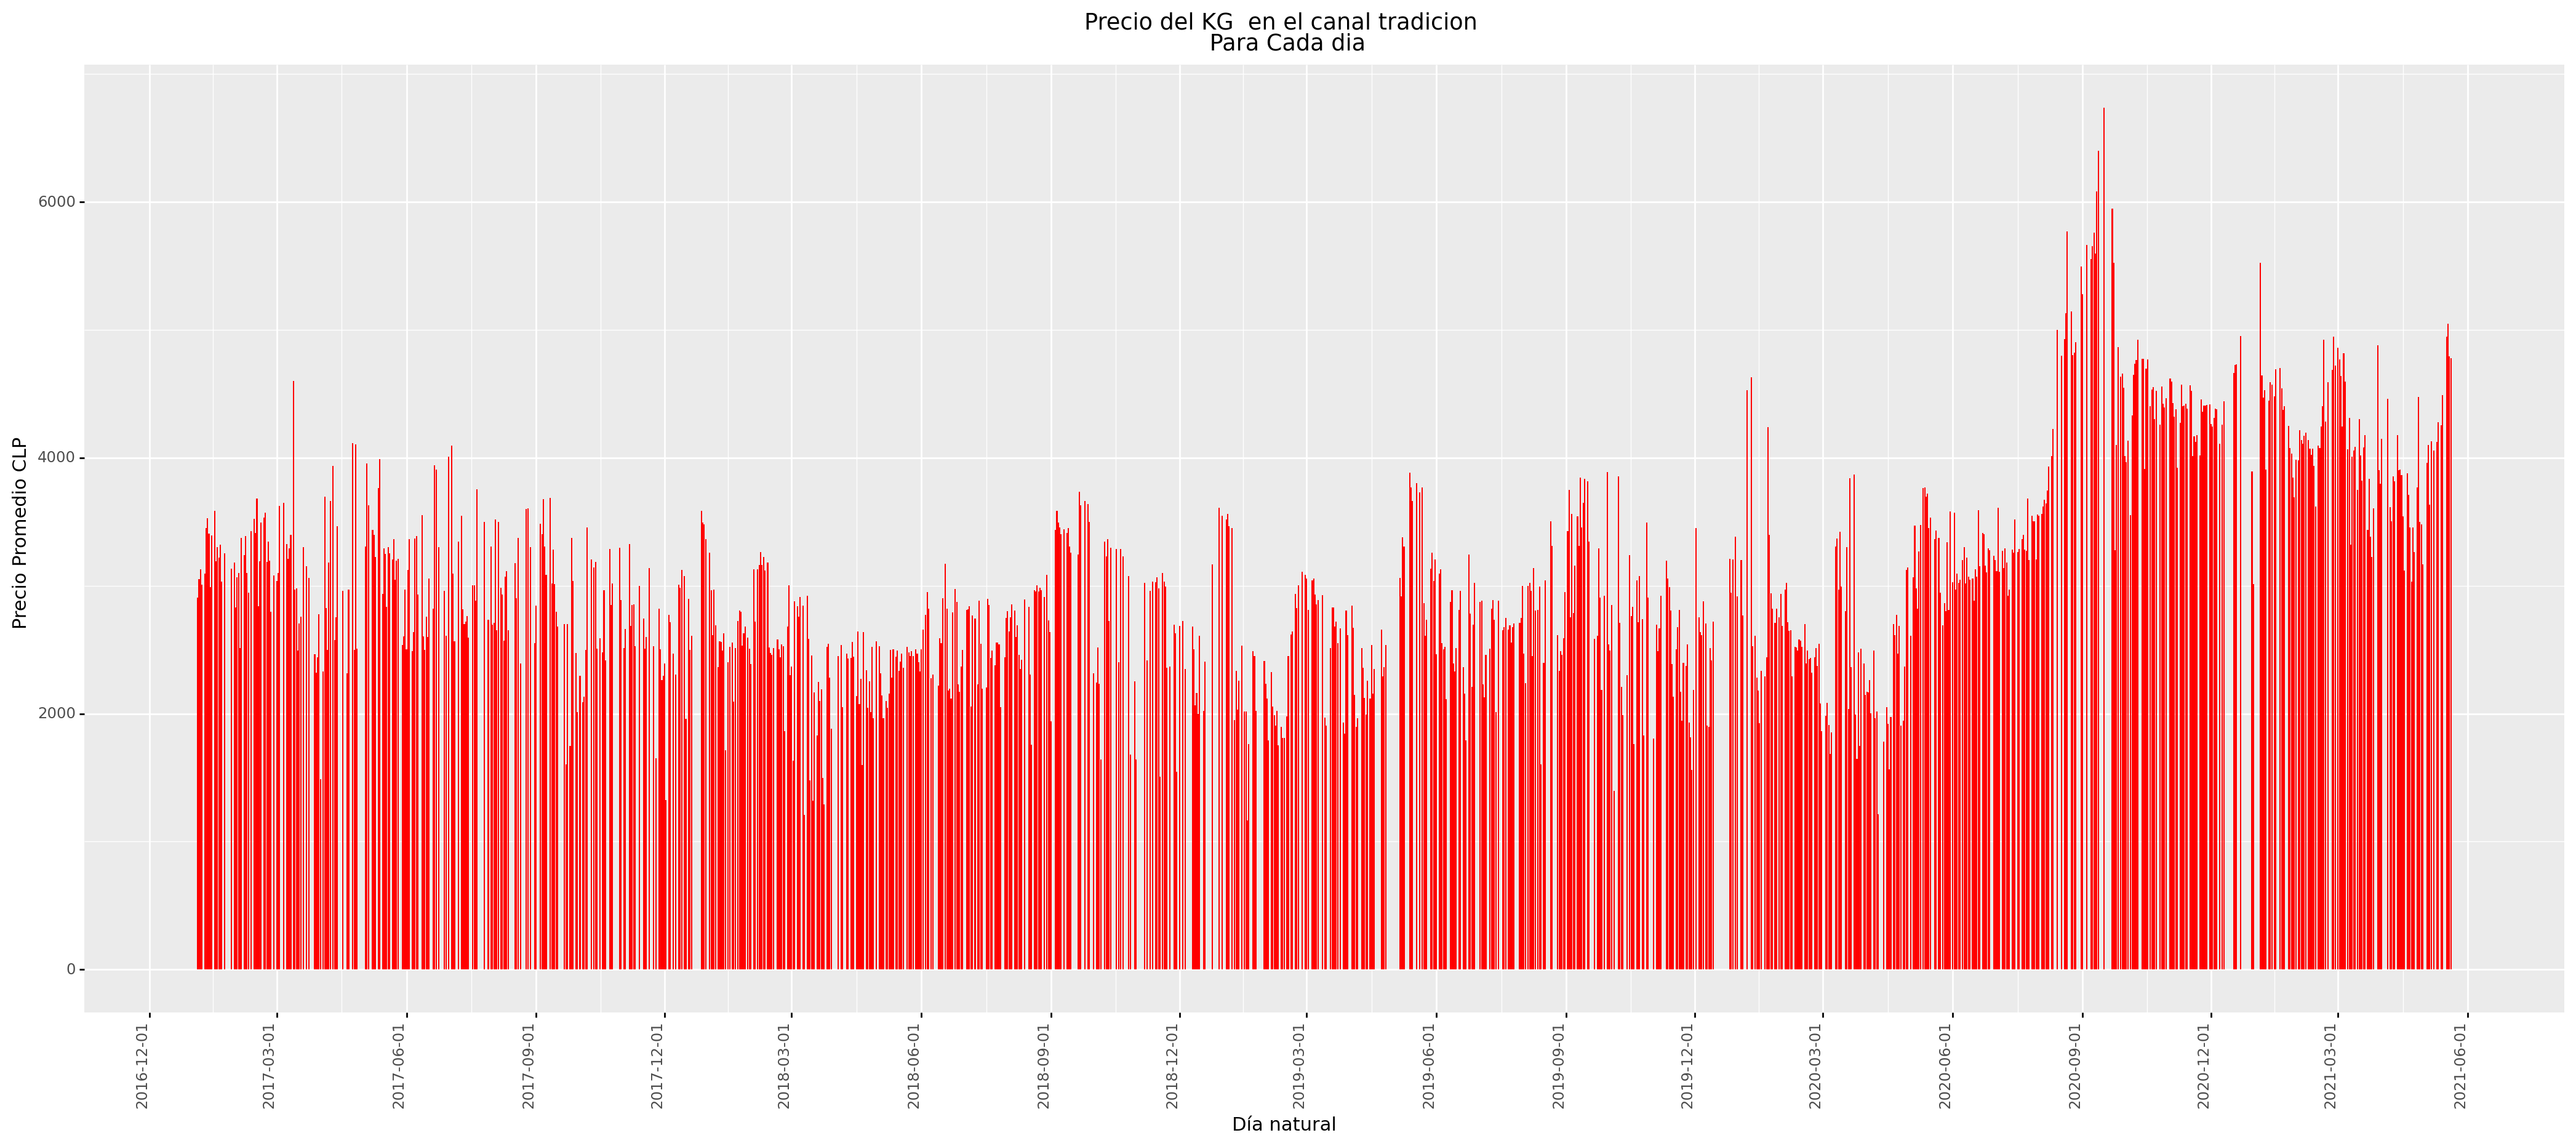

<ggplot: (166677445795)>

In [30]:
Prec=(
    ggplot(DF_prophet, aes(x='Día natural',y= y_col))                 
                + geom_col(fill='red',alpha=1)\
                #+ labs(y='Volumen en KG',x='Día natural',size=14)\
                +ggtitle((y_title+
                          ' \n Para Cada dia'))\
                +theme(axis_text_x = element_text(angle=90, hjust=1)
                       ,figure_size=(26,10))
                 #+ scale_x_continuous(breaks=X_brak,labels=X_brak_S)
                + scale_x_datetime(breaks=date_breaks('3 month'))  
    )
Prec

#### Creación columna Año

In [31]:
DF_prophet['Año']=DF_prophet['Día natural'].apply( lambda x: x.year)
DF_prophet['Año'].head()

0    2017
1    2017
2    2017
3    2017
4    2017
Name: Año, dtype: int64

### Comportamiento Año a Año 

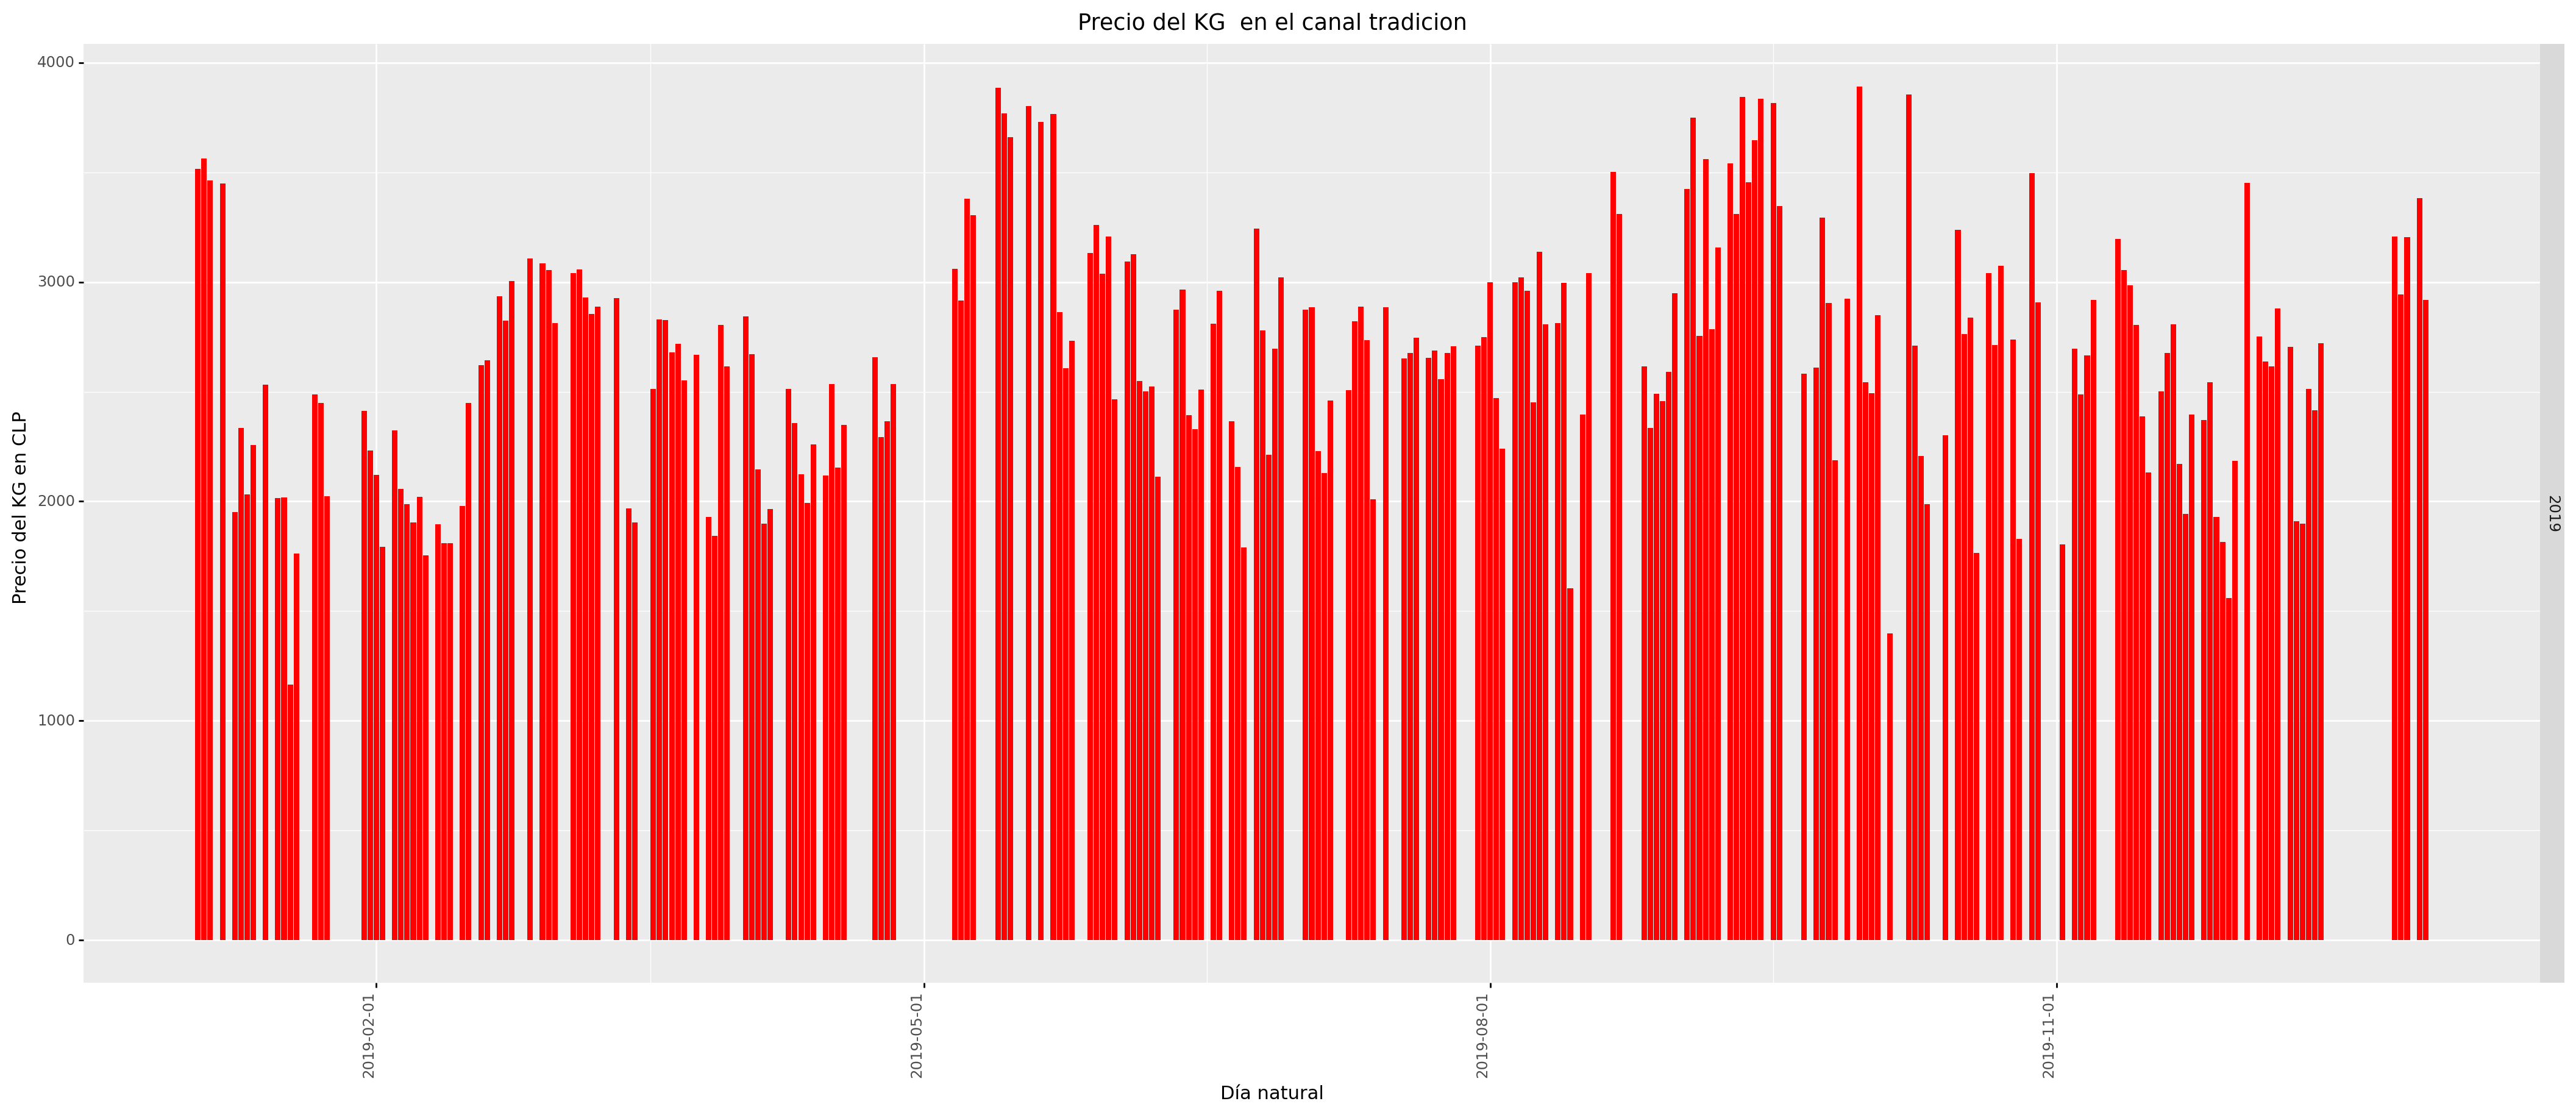

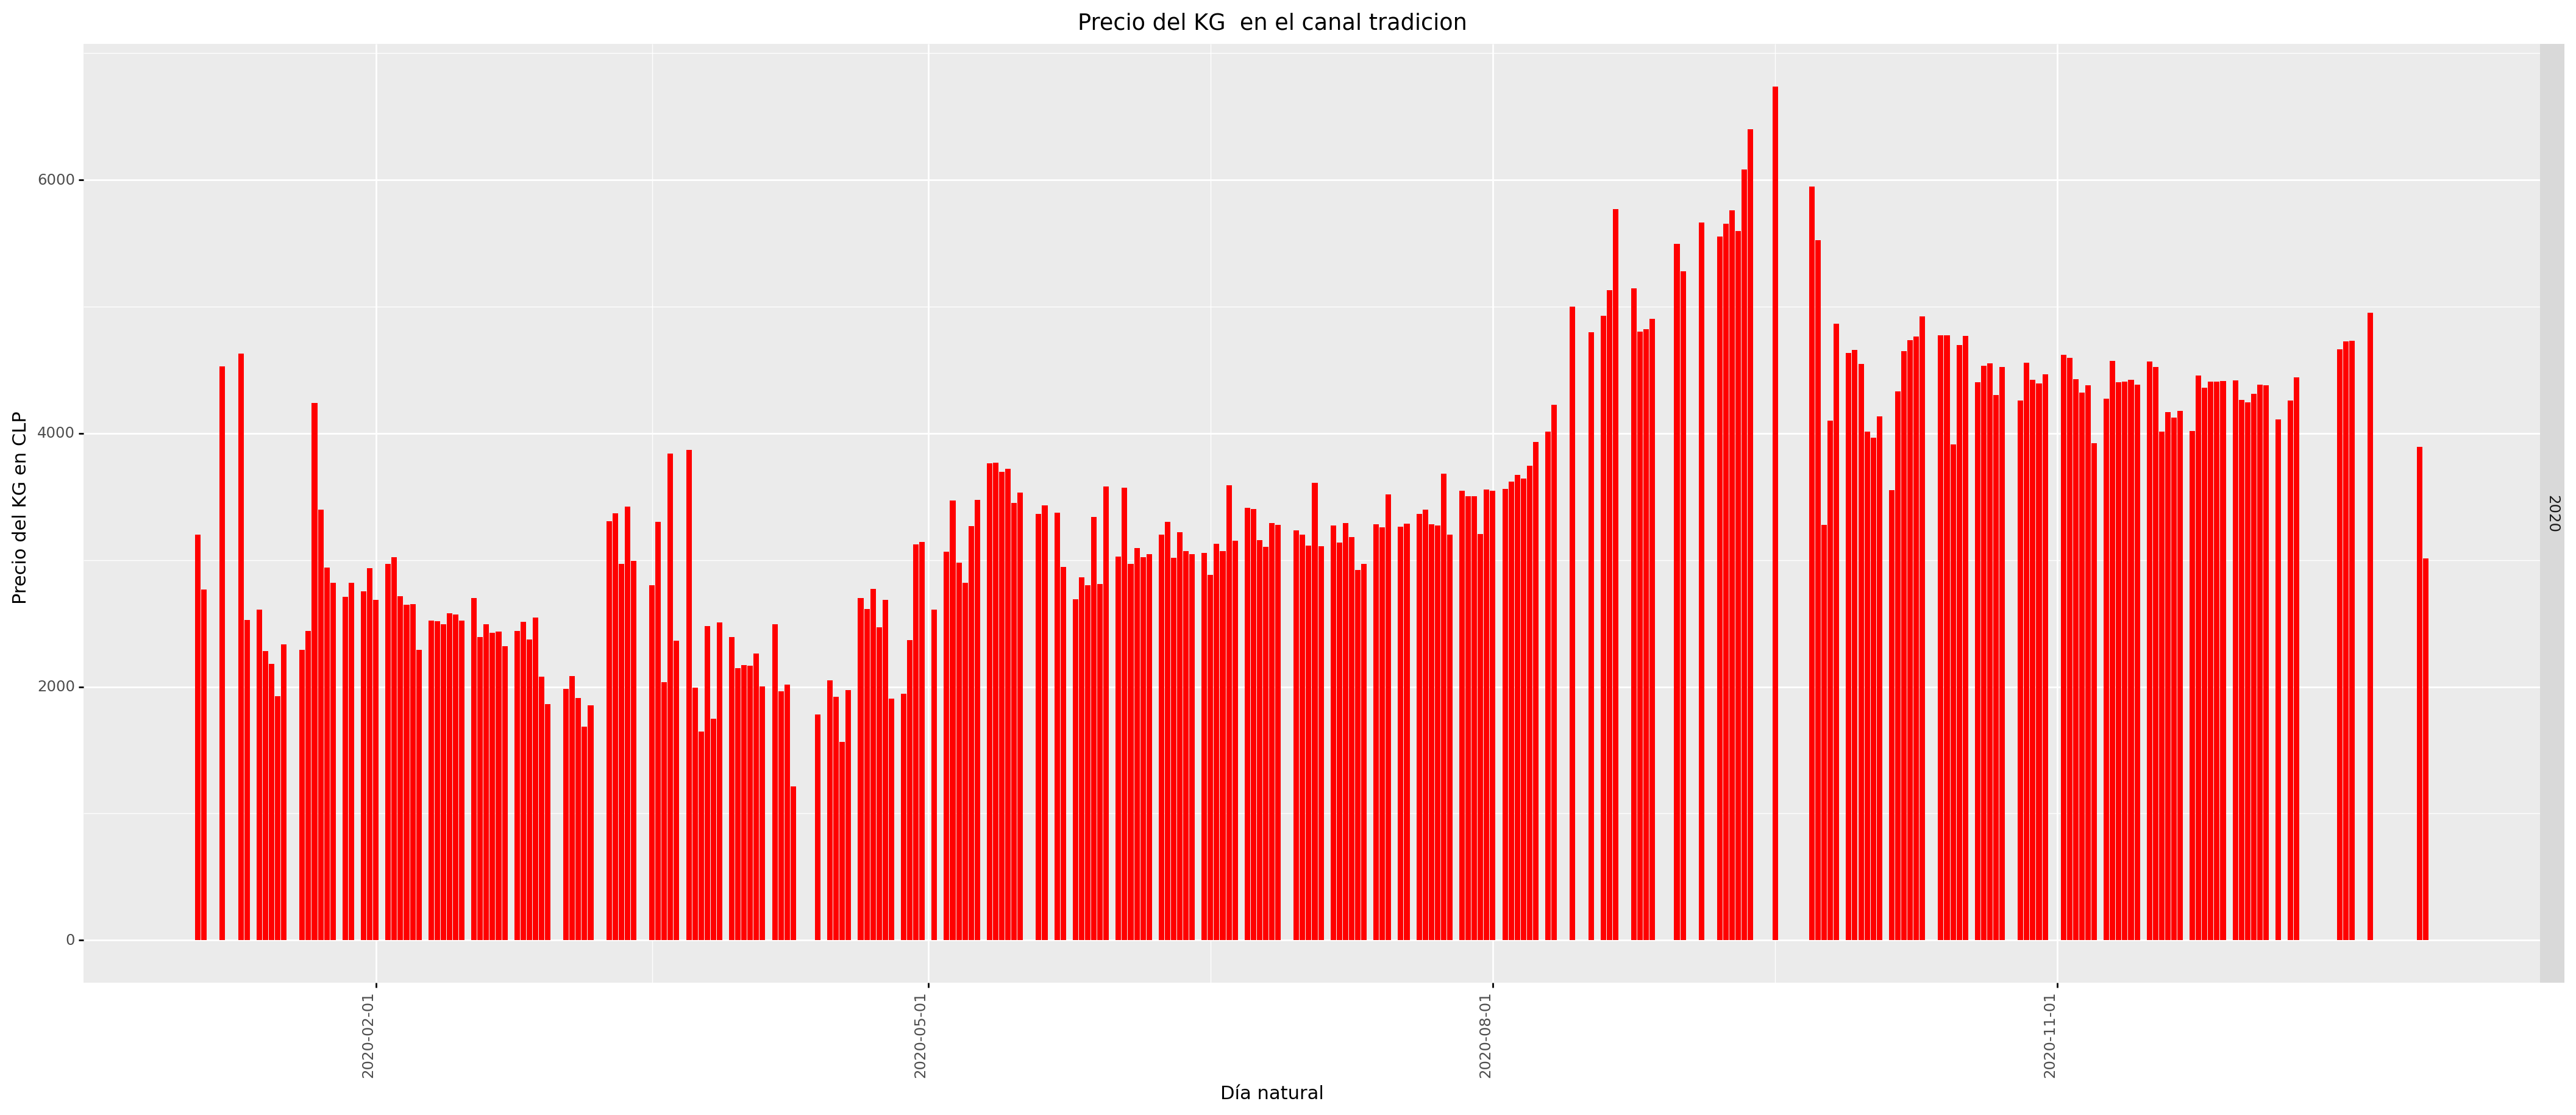

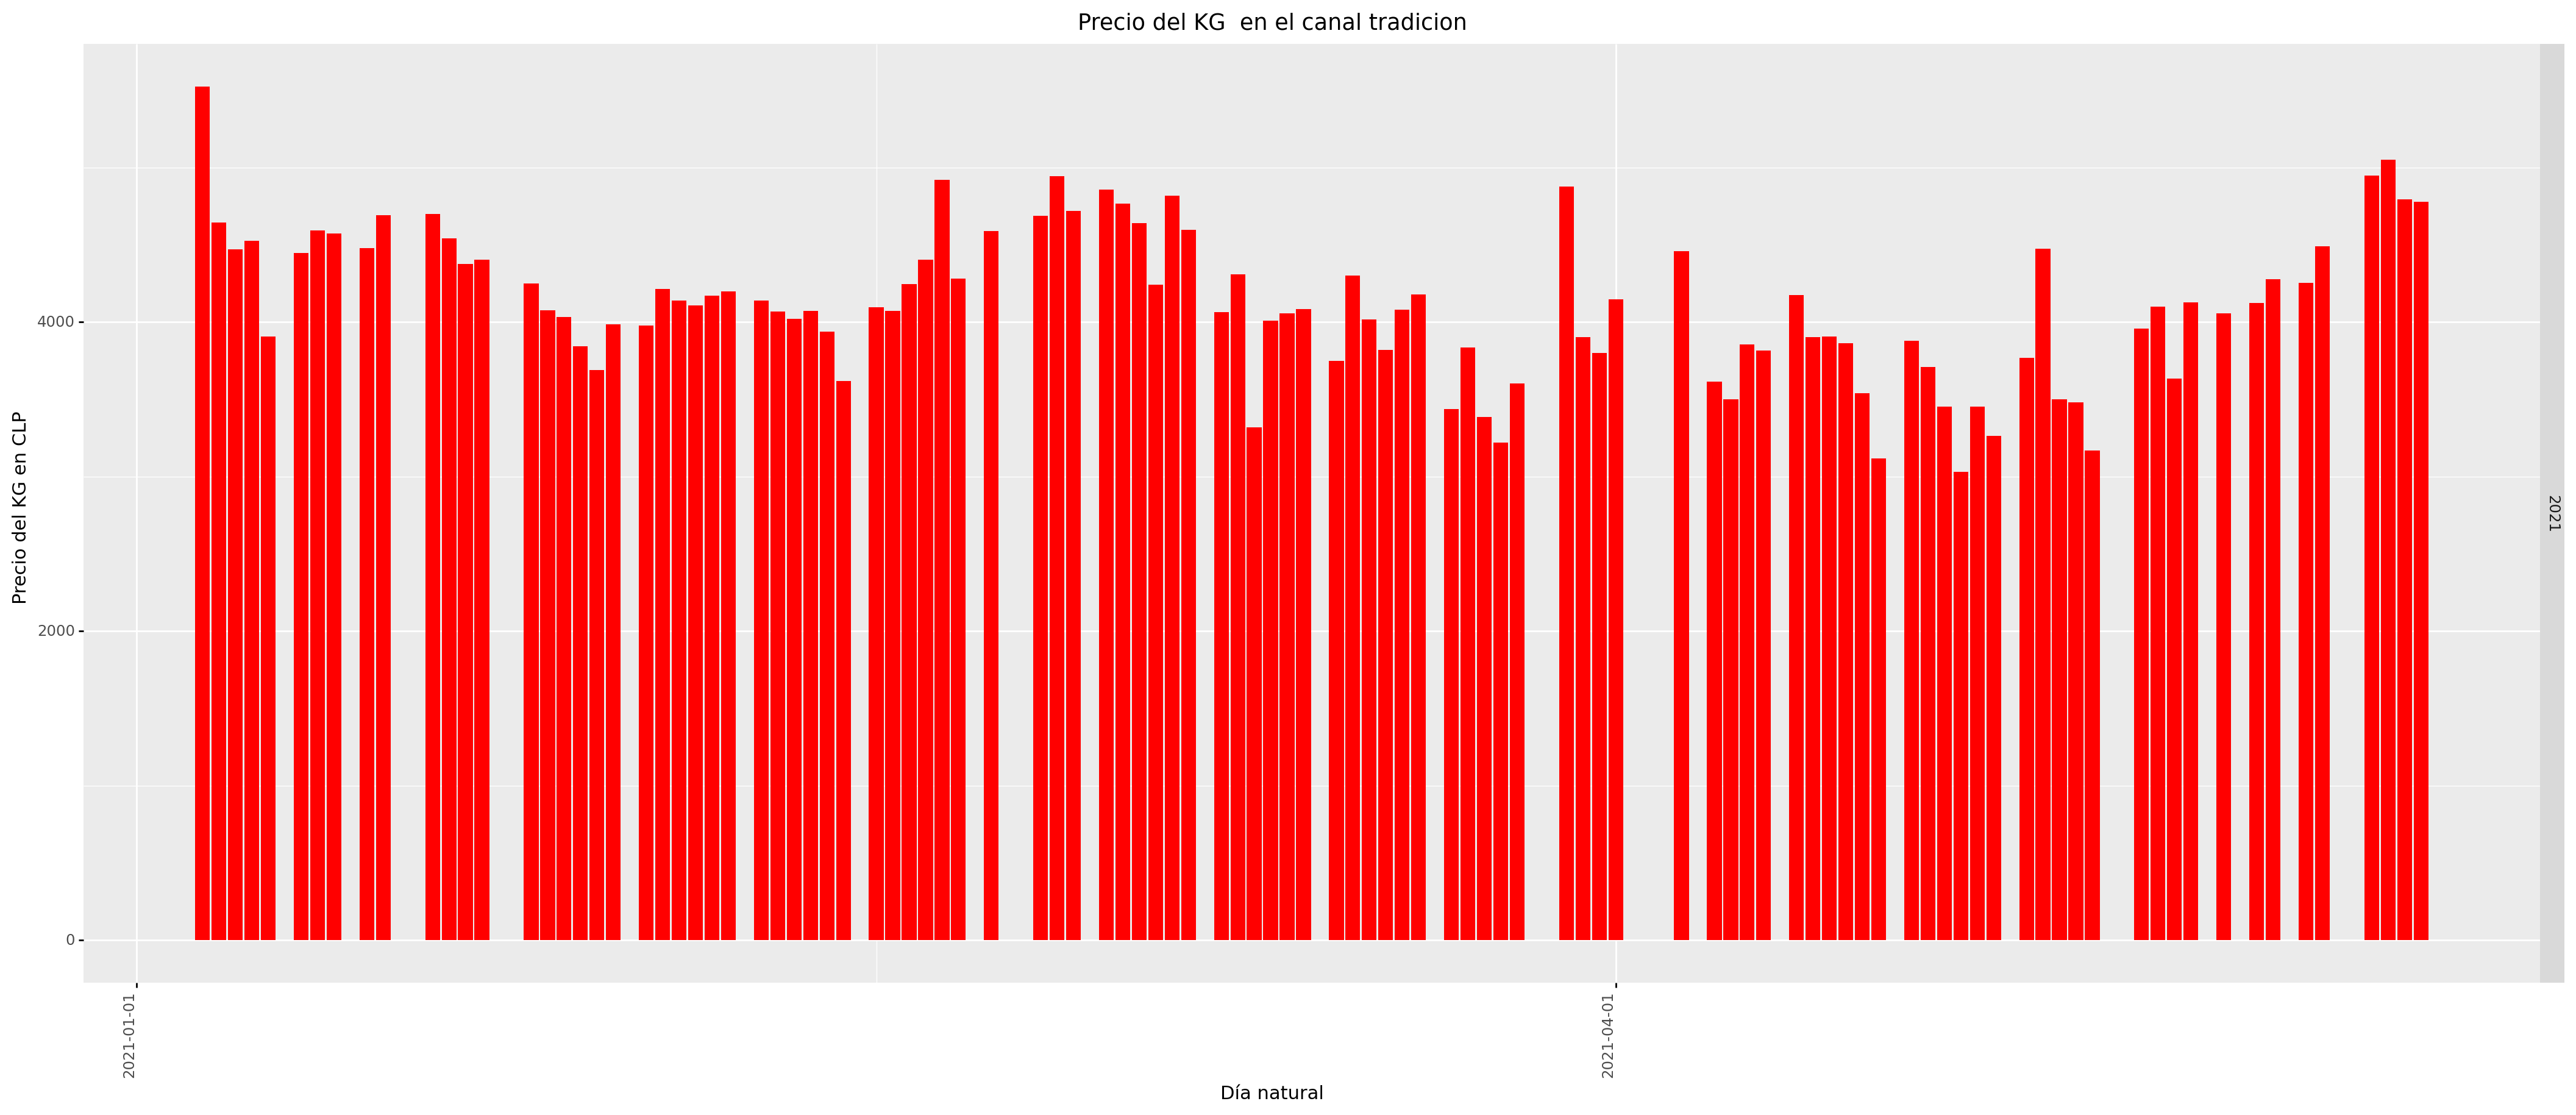

[<ggplot: (166677179383)>, <ggplot: (166677204357)>, <ggplot: (166677041975)>]

In [32]:
#DF_VS

Dem=[
    ggplot(DF_prophet[DF_prophet['Año']==i], aes(x='Día natural',y=y_col))                 
                + geom_col(fill='red',alpha=1)\
                +facet_grid('Año~.')\
                + labs(y=y_value,x='Día natural',size=14)\
                +ggtitle((y_title))\
                +theme(axis_text_x = element_text(angle=90, hjust=1)
                       ,figure_size=(26,10))
                 #+ scale_x_continuous(breaks=X_brak,labels=X_brak_S)
                + scale_x_datetime(breaks=date_breaks('3 month')) for i in [2019,2020,2021]
]
Dem

## Sección Prophet  Predicción Demanda

### Construcción del Data Frame 

In [33]:
df_P=DF_prophet[['Día natural', y_col]].copy()
df_P.columns = ['ds','y']

#FECHA DE INICIO
df_P=df_P[df_P.ds>=datetime.date(2019, 1, 1)]
df_P.head()
#print_simpl_graph(df_P)

,ds,y
485,2019-01-03,3516.219512
486,2019-01-04,3562.045455
487,2019-01-05,3463.409091
488,2019-01-07,3449.250000
489,2019-01-09,1950.298805


####  Data Entrenamiento y prueba

`DF_Frecuent` pertenece a los datos del segemnto utilizado

df_P:= Data completa

In [34]:
#FECHA DE TERMINO
df_P_train=df_P[df_P.ds<datetime.date(2021, 1, 1)]

#FECHA DE PRUEBA
df_P_test=df_P[df_P.ds>datetime.date(2021, 1, 1)]

In [35]:
D_propht_Train=df_P_train
D_propht_Test=df_P_test

In [36]:
# column names for prophet compliance
D_propht_Train.columns = ['ds','y']
#D_propht.head(3)

# convert dates from string to datetime
D_propht_Train.ds = pd.to_datetime(D_propht_Train.ds)
print(D_propht_Train.dtypes)

# convert dates from string to datetime
D_propht_Test.ds = pd.to_datetime(D_propht_Test.ds)
print(D_propht_Test.dtypes)

# convert dates from string to datetime
df_P.ds = pd.to_datetime(df_P.ds)
print(df_P.dtypes)

ds    datetime64[ns]
y            float64
dtype: object
ds    datetime64[ns]
y            float64
dtype: object
ds    datetime64[ns]
y            float64
dtype: object


D_propht_Train


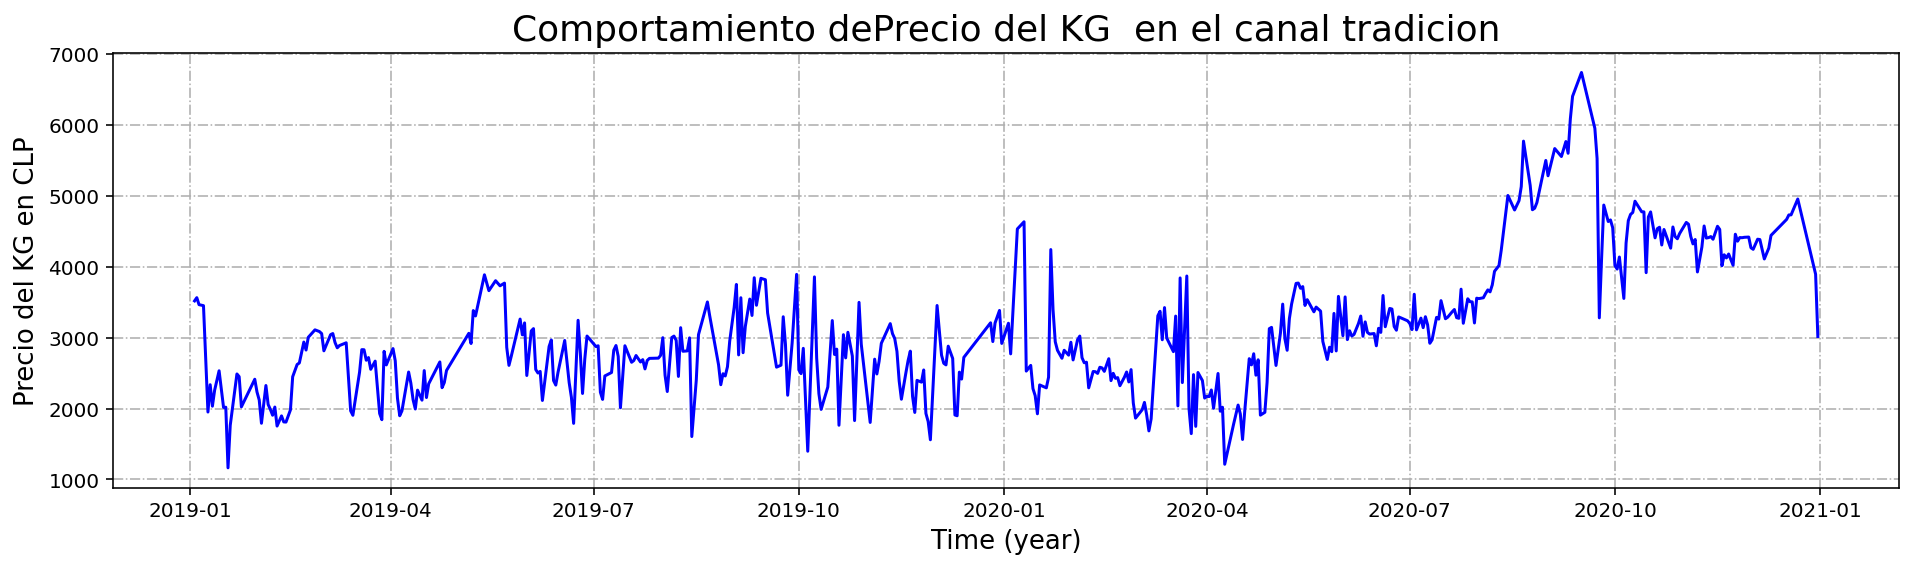

D_propht_Test


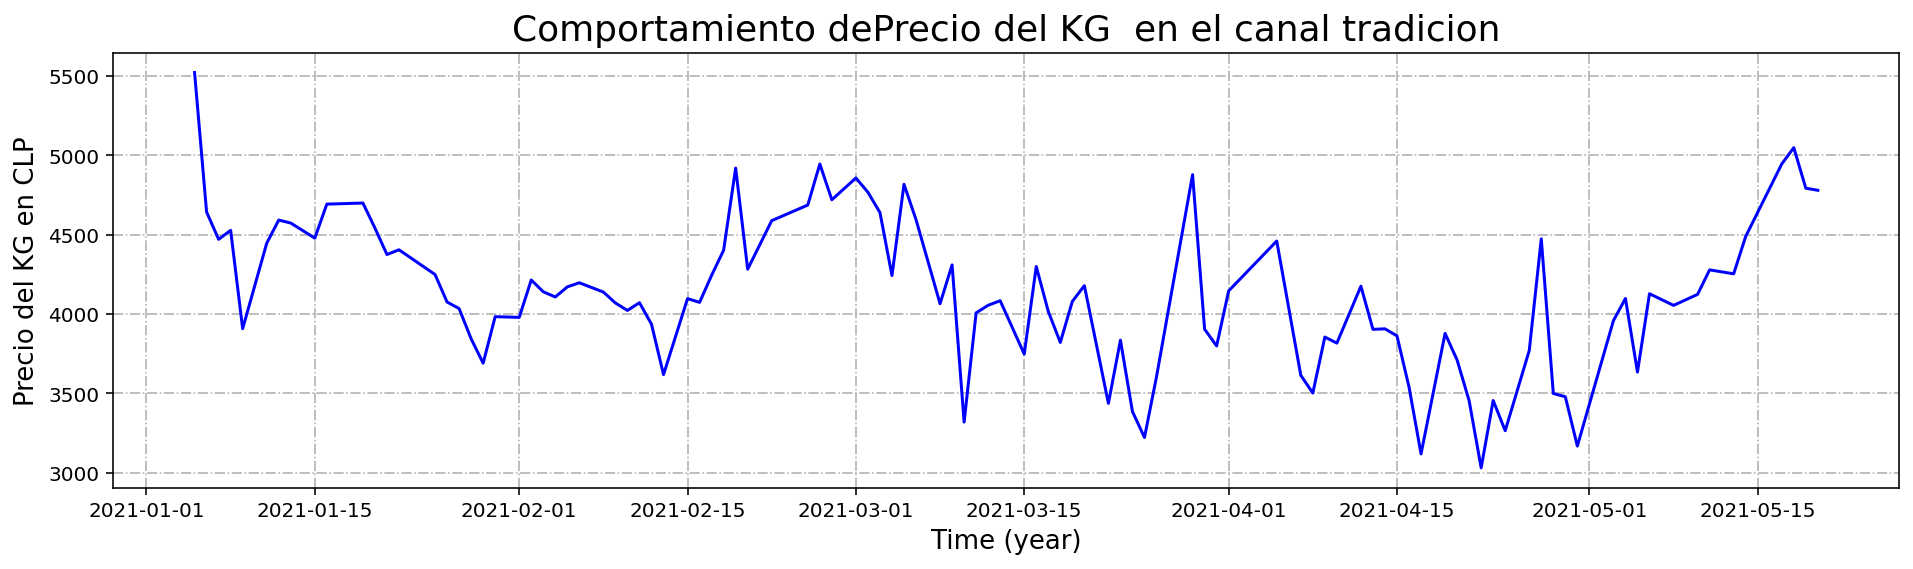

In [37]:
#imprime la grafica de dispersión de los datos
print('D_propht_Train')
print_simpl_graph(D_propht_Train)

print('D_propht_Test')
print_simpl_graph(D_propht_Test)

###  Entrenamiento del modelo

In [38]:

# set prophet model 
prophet = Prophet(changepoint_prior_scale=0.15, yearly_seasonality=True)

# fit $wmt data to model
prophet.fit(D_propht_Train)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#### Define la amplitud de la predicción 

In [39]:
largo=D_propht_Test.ds.iloc[0]-D_propht_Test.ds.iloc[D_propht_Test.shape[0]-1]
prophet.make_future_dataframe(periods= abs(largo.days)+5 , freq='D').tail()

,ds
638,2021-05-16
639,2021-05-17
640,2021-05-18
641,2021-05-19
642,2021-05-20


In [40]:
D_propht_Test.tail()

,ds,y
1087,2021-05-14,4489.125000
1088,2021-05-17,4946.311475
1089,2021-05-18,5049.000000
1090,2021-05-19,4793.349754
1091,2021-05-20,4780.349754


#### Se efectua la predicción 

In [41]:

# build future dataframe for 5 years
build_forecast = prophet.make_future_dataframe(periods= abs(largo.days)+5, freq='D')
# es el df con el cual se creará las predicciones, 
#60 es cuantos dias sobresale de la data

#se puede reemplazar con el conjunto completo de datos
#build_forecast['ds']=pd.to_datetime(df_P.reset_index()['ds'])

# forecast future df w/ model
forecast = prophet.predict(build_forecast)



In [42]:
forecast.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-03,2531.867660,2145.317237,3251.606706,2531.867660,2531.867660,186.970102,186.970102,186.970102,-177.457397,-177.457397,-177.457397,364.427498,364.427498,364.427498,0.0,0.0,0.0,2718.837762
1,2019-01-04,2539.602273,2224.734599,3351.304866,2539.602273,2539.602273,242.048903,242.048903,242.048903,-97.118253,-97.118253,-97.118253,339.167155,339.167155,339.167155,0.0,0.0,0.0,2781.651176


###  grafica dispersion prediccion

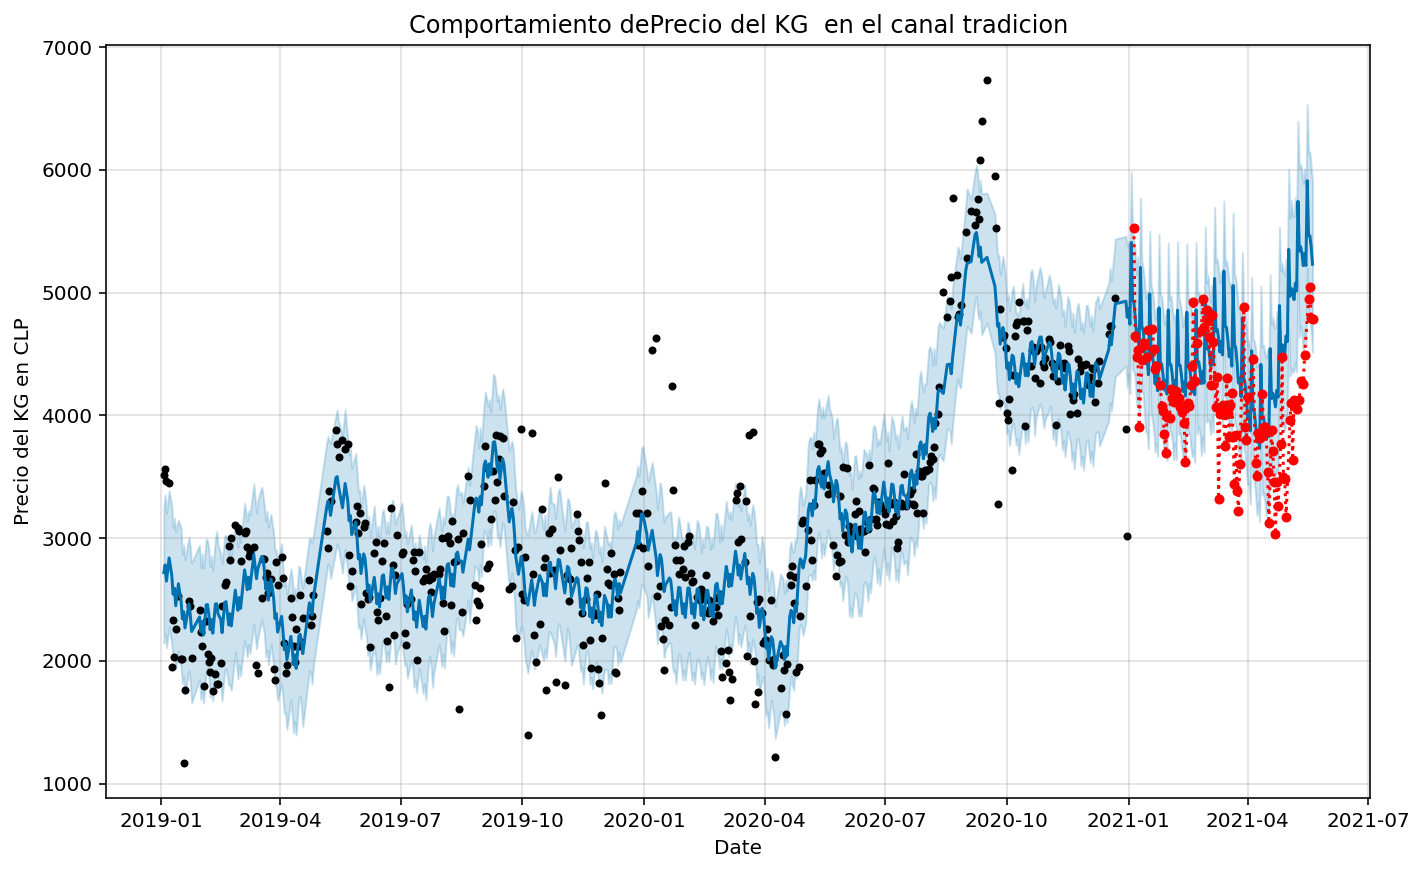

In [43]:
#plot forecasts
prophet.plot(forecast, xlabel='Date', ylabel= y_value)
#plt.grid(linestyle='-.')
plt.plot(D_propht_Test.ds, D_propht_Test.y, color='red', marker='o', linestyle=':',markersize=4,)
plt.title('Comportamiento de'+ y_title)
# display graph
plt.show()



### Componentes(Funciones) de Prophet

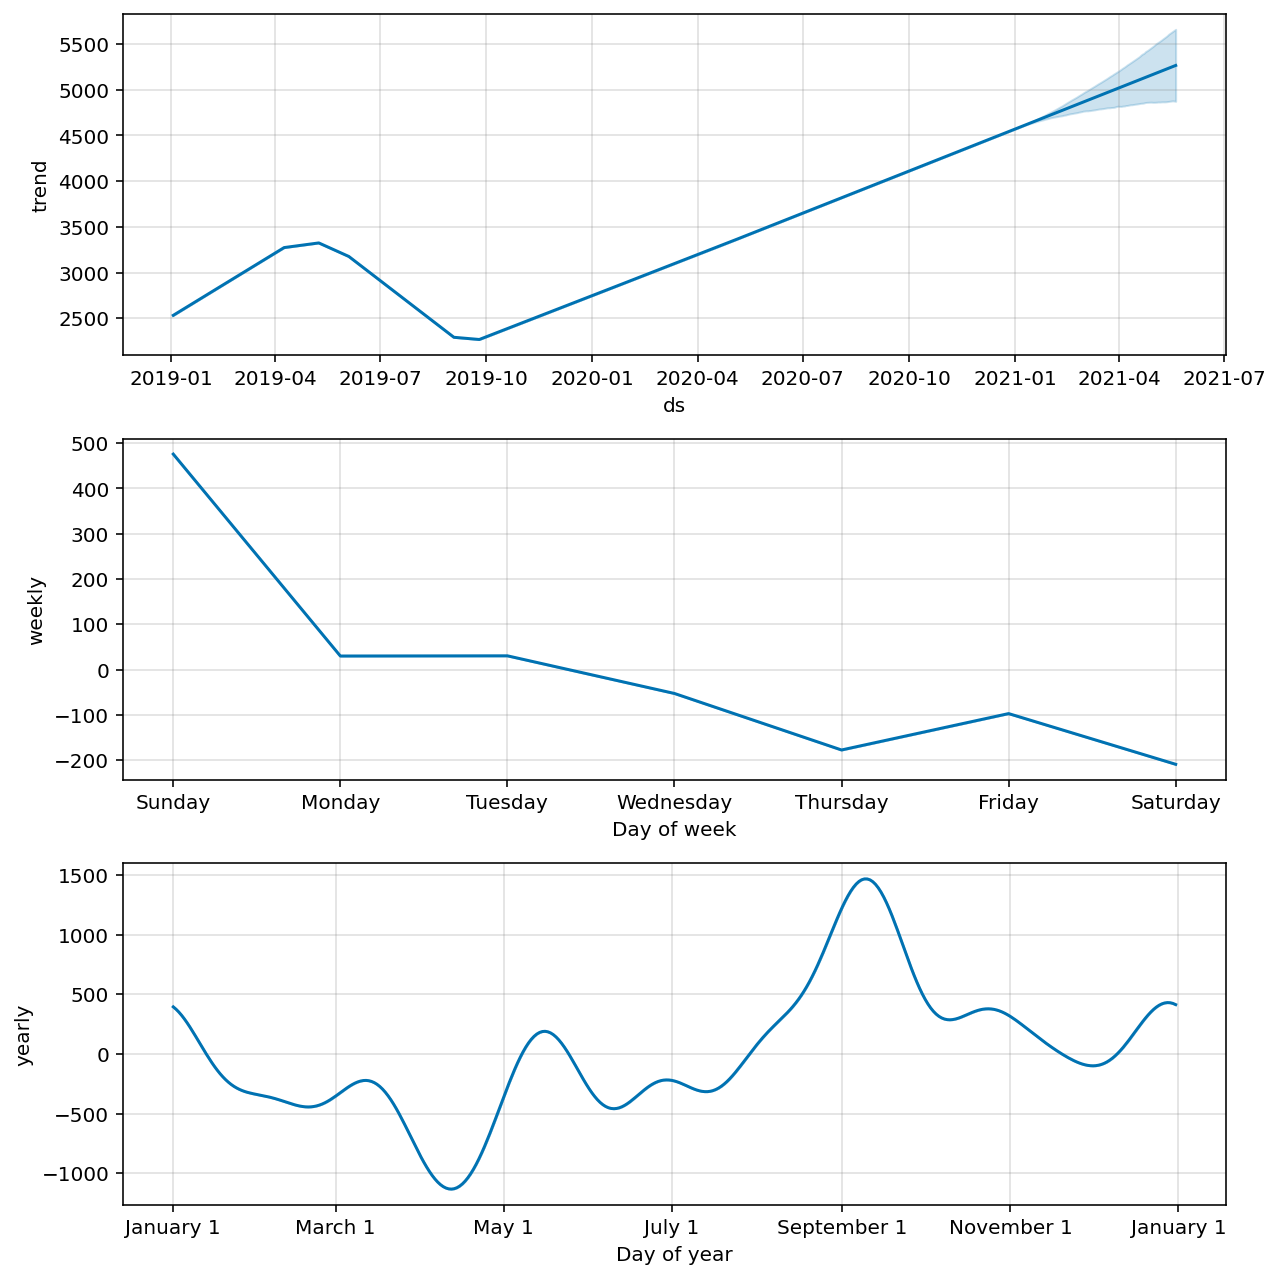

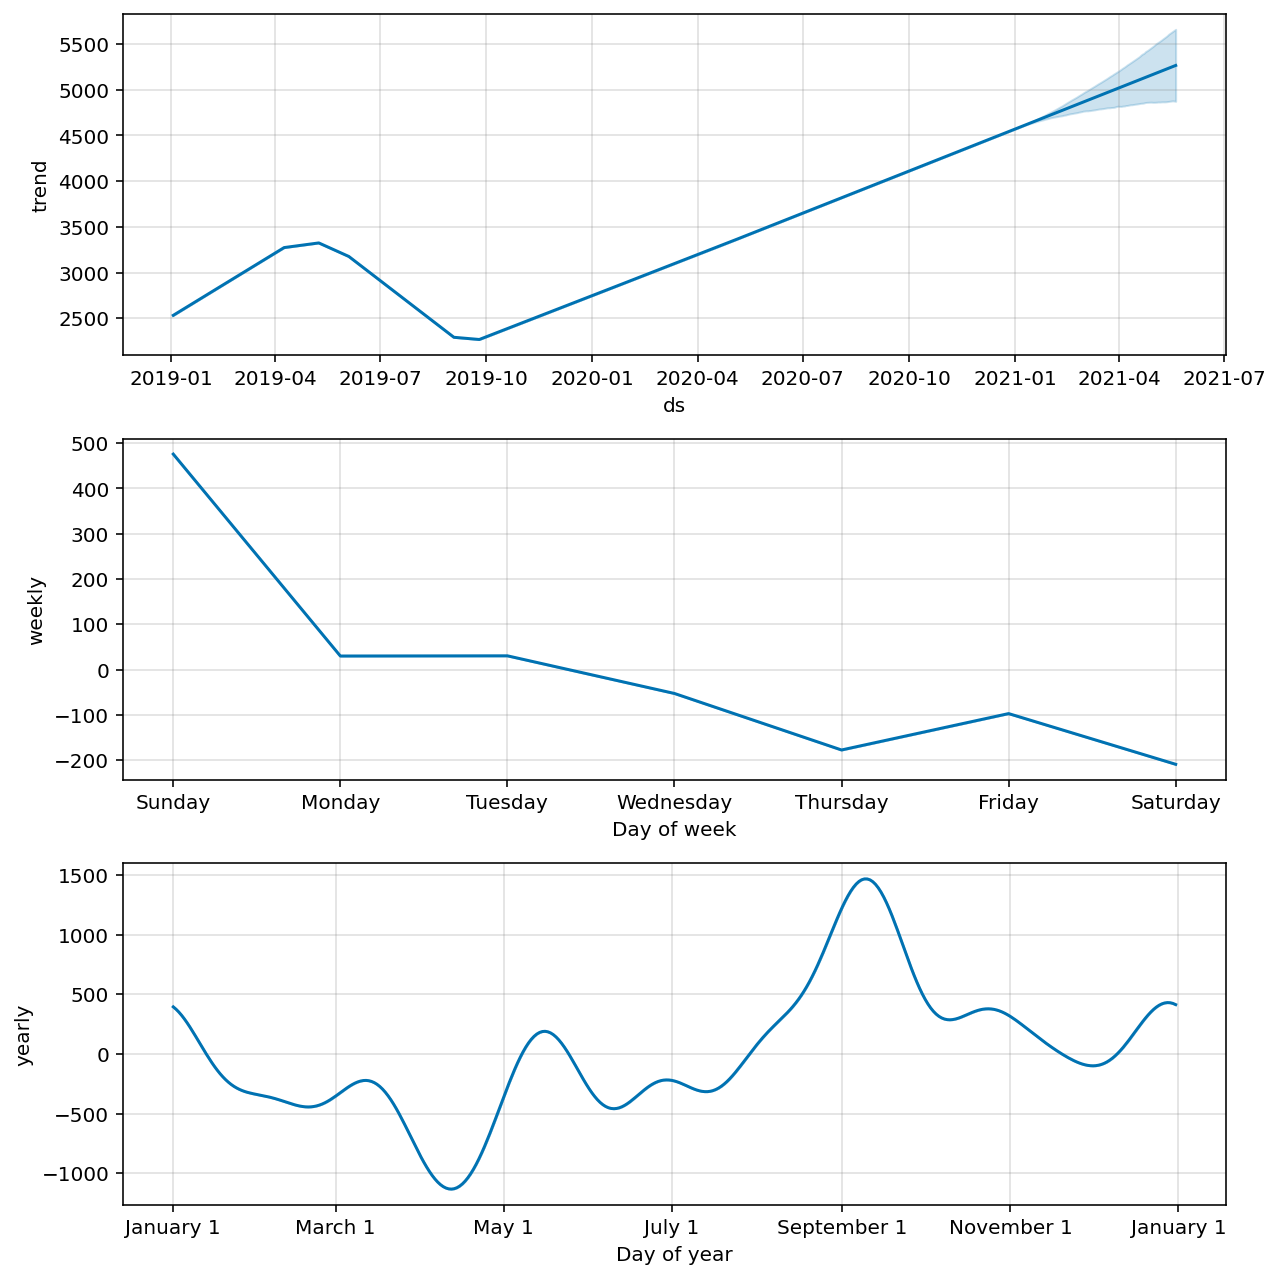

In [44]:
# tell us more about the forecast
prophet.plot_components(forecast)

## calclulo del error


\begin{equation}
Error_{Prophet}=Predicción-Valor.Real
\end{equation}

Cuando el error es **negativo** significa que el modelo **subestimo** el valor real
\begin{equation}
Predicción<Valor.Real
\end{equation}



Cuando el error es **Positivo** significa que el modelo **sobrestimo** el valor real

\begin{equation}
Predicción>Valor.Real
\end{equation}


Se toma en cuenta el DF `forecast[['ds','yhat']]`

Este para contrastarlo con los datos reales se hace un merge con la data de prueba `D_propht_Test`

In [45]:
#Defino un DF con solo las col que me interesan del DF forecast
pred_2021=forecast[['ds','yhat']]

In [46]:
# hace un merge con la data de prueba 
dfx=pd.merge(pred_2021, D_propht_Test  
     , how='right')
dfx['Error']=dfx.yhat-dfx.y
dfx.head()

,ds,yhat,y,Error
0,2021-01-05,4915.458823,5522.940476,-607.481653
1,2021-01-06,4804.574773,4643.523077,161.051696
2,2021-01-07,4649.842147,4471.044643,178.797504
3,2021-01-08,4698.500514,4527.781250,170.719264
4,2021-01-09,4553.670097,3907.805556,645.864541


<AxesSubplot:>

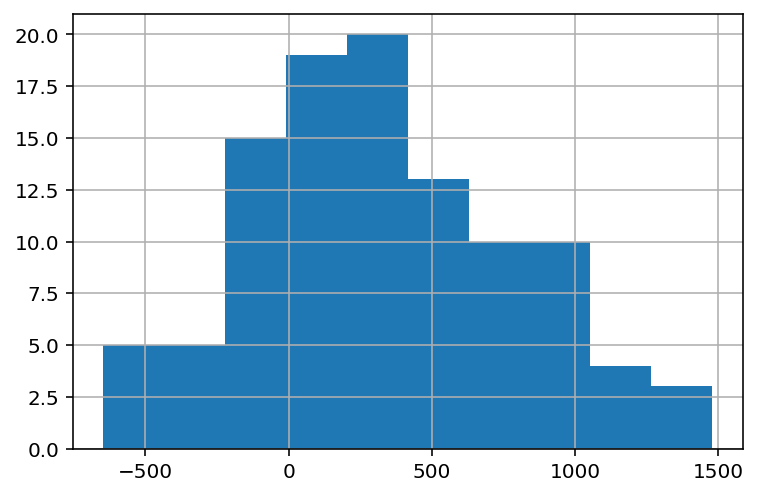

In [47]:
dfx.Error.hist()

In [48]:
tempo=dfx.copy()
tempo['Semana']=tempo.ds.apply(lambda x: x.week).astype('category')
tempo['Mes']=tempo.ds.apply(lambda x: x.month).astype('category')
tempo.Error=tempo.Error.astype('float64')#.abs()
tempo.Error.sum()#/tempo.shape[0]

34278.918903113736

####  histograma del eroor por semana

(21, 5)


<AxesSubplot:>

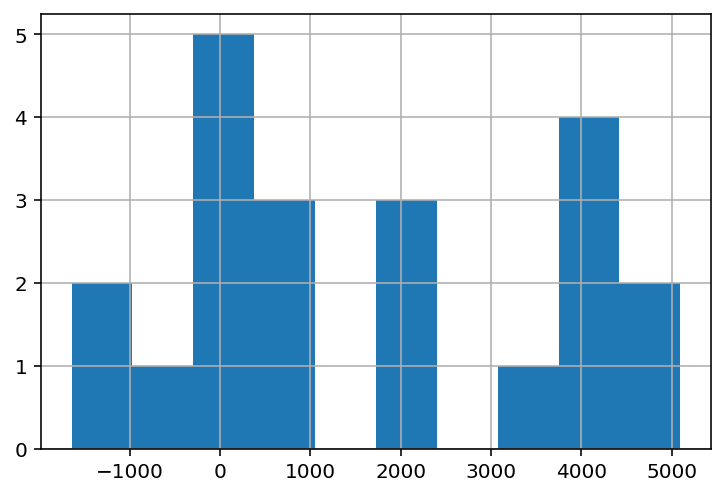

In [49]:
tmp=tempo.groupby(['Mes','Semana']).sum().reset_index()
# como es categorico, generá valores 0 para las columnas 
#que no tienen registros en el mes.
#para evitar esto, se filtran los valores menos a 0.
tmp=tmp[tmp.y > 0]
print(tmp.shape)
tmp.Error.hist()

In [50]:
tmp.head()

,Mes,Semana,yhat,y,Error
0,1,1,23622.046354,23073.095002,548.951353
1,1,2,22794.524545,22784.675259,9.849285
2,1,3,17474.470140,18022.843647,-548.373506
3,1,4,25836.525300,23878.027882,1958.497417
24,2,5,25820.862685,24810.477796,1010.384889


In [51]:
286.894011/637

0.4503830627943485

#### graffica anance del erro semana a semana 

In [52]:
tmp[tmp.Semana==13]

,Mes,Semana,yhat,y,Error
52,3,13,12708.450201,12582.420653,126.029548
72,4,13,3976.129221,4146.138158,-170.008937


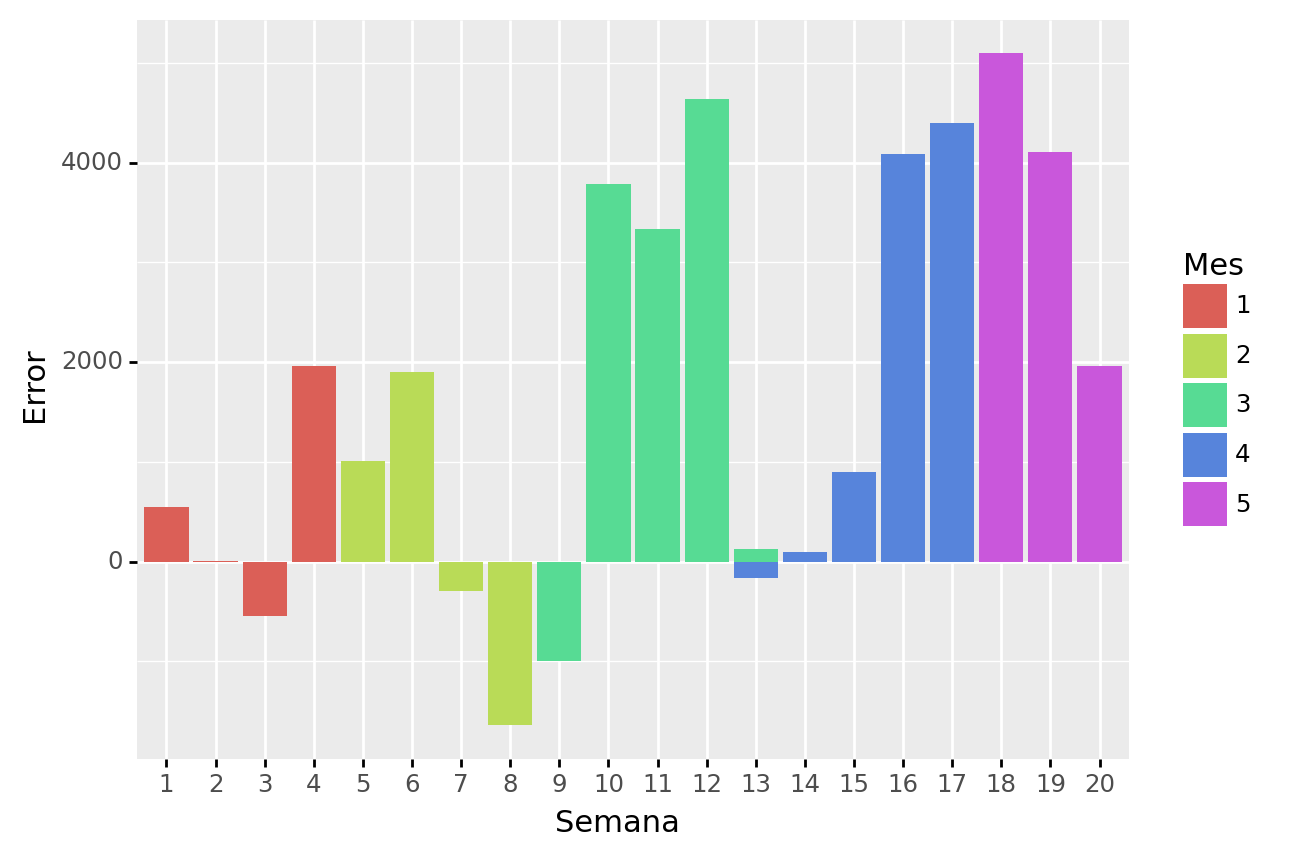

<ggplot: (166677446256)>

In [53]:
ggplot(tmp, aes(x=tmp.Semana,y='Error'))+\
geom_col(aes(fill='Mes'))

#### grafica del error mensual 

In [54]:
tmp2=tmp.copy()
tmp2.Error=tmp2.Error.astype('float64')#.abs()
tmp2.Mes=tmp2.Mes.astype('category')

print(tmp2.Error.mean())

dx=tmp2.groupby('Mes').sum().reset_index()#['Mes','Error']
dx

1632.3294715768443


,Mes,yhat,y,Error
0,1,89727.566338,87758.641790,1968.924548
1,2,94607.704005,93631.929706,975.774299
2,3,116849.830126,105975.084052,10874.746074
3,4,94384.079819,85083.583306,9300.496514
4,5,67747.356764,56588.379296,11158.977468


In [55]:
tmp[tmp.Mes==5]

,Mes,Semana,yhat,y,Error
97,5,18,24967.739817,19873.797483,5093.942334
98,5,19,21249.978719,17145.570831,4104.407888
99,5,20,21529.638229,19569.010983,1960.627246


In [56]:
dx.Error=dx.Error.astype('float64').abs()
dx

,Mes,yhat,y,Error
0,1,89727.566338,87758.641790,1968.924548
1,2,94607.704005,93631.929706,975.774299
2,3,116849.830126,105975.084052,10874.746074
3,4,94384.079819,85083.583306,9300.496514
4,5,67747.356764,56588.379296,11158.977468


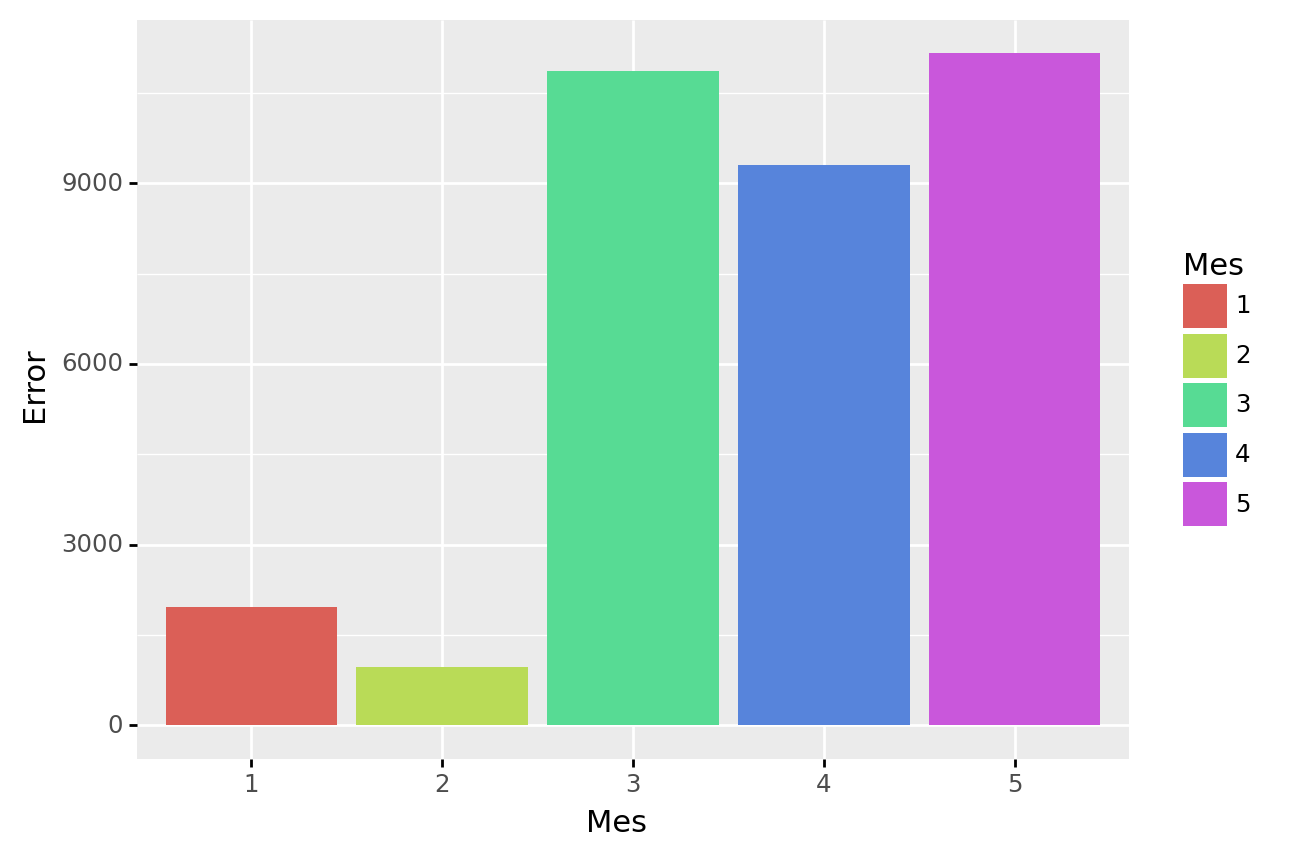

<ggplot: (166680901325)>

In [57]:
ggplot(dx, aes(x=dx.Mes,y='Error'))+\
geom_col(aes(fill='Mes'))

### Error porcentual 

\begin{equation}
Error_{Porcentual}=\dfrac{predicción}{valor real}-1
\end{equation}

In [58]:
tmp['Error porcentual']=tmp.yhat/tmp.y-1

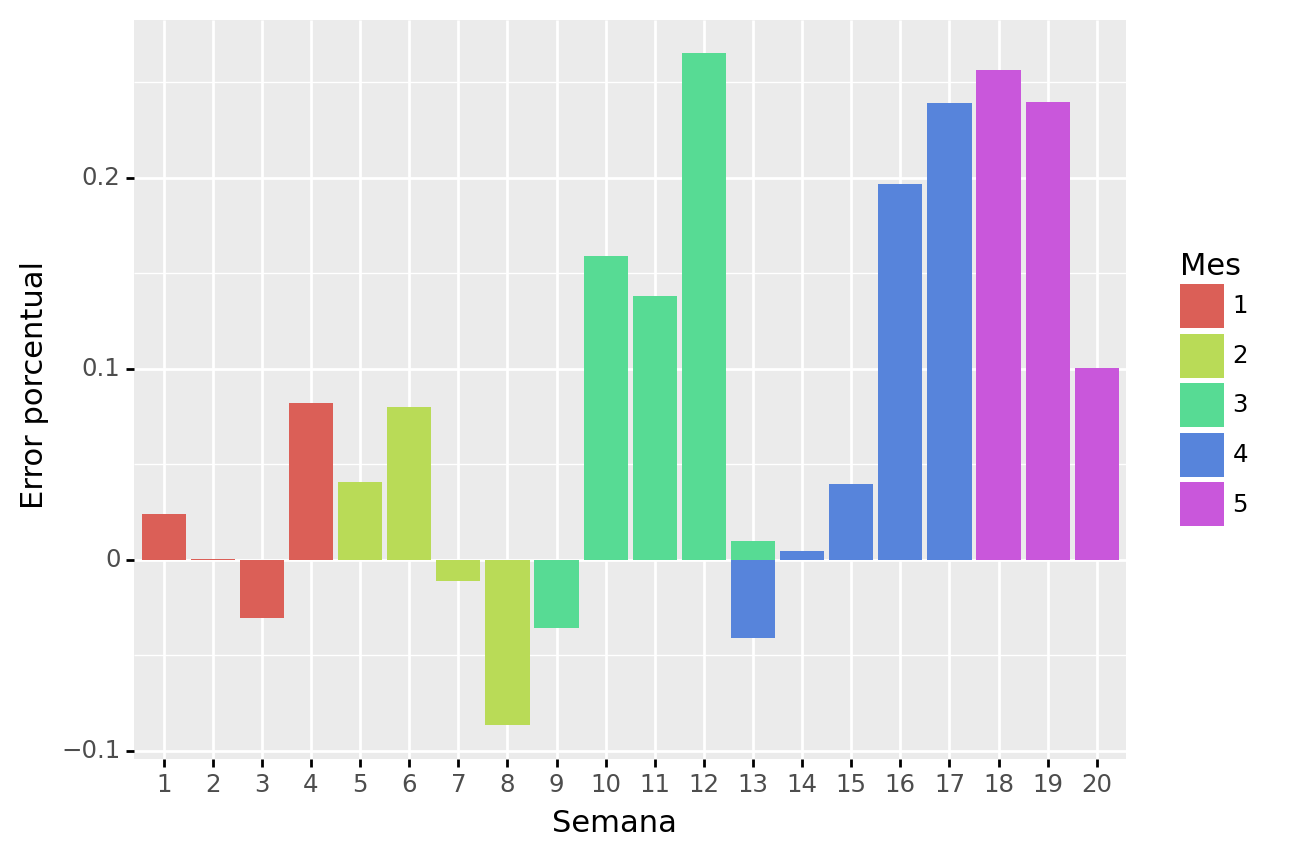

<ggplot: (166680921290)>

In [59]:
ggplot(tmp, aes(x=tmp.Semana,y='Error porcentual'))+\
geom_col(aes(fill='Mes'))

In [60]:
tmp2=tmp.copy()
tmp2.Error=tmp2.Error.astype('float64')#.abs()
tmp2['Error porcentual']=tmp2['Error porcentual'].astype('float64')#.abs()
print(tmp2.Error.mean())
dx=tmp2.groupby(['Mes']).sum().reset_index()#['Mes','Error','Error/Demanda real']

1632.3294715768443


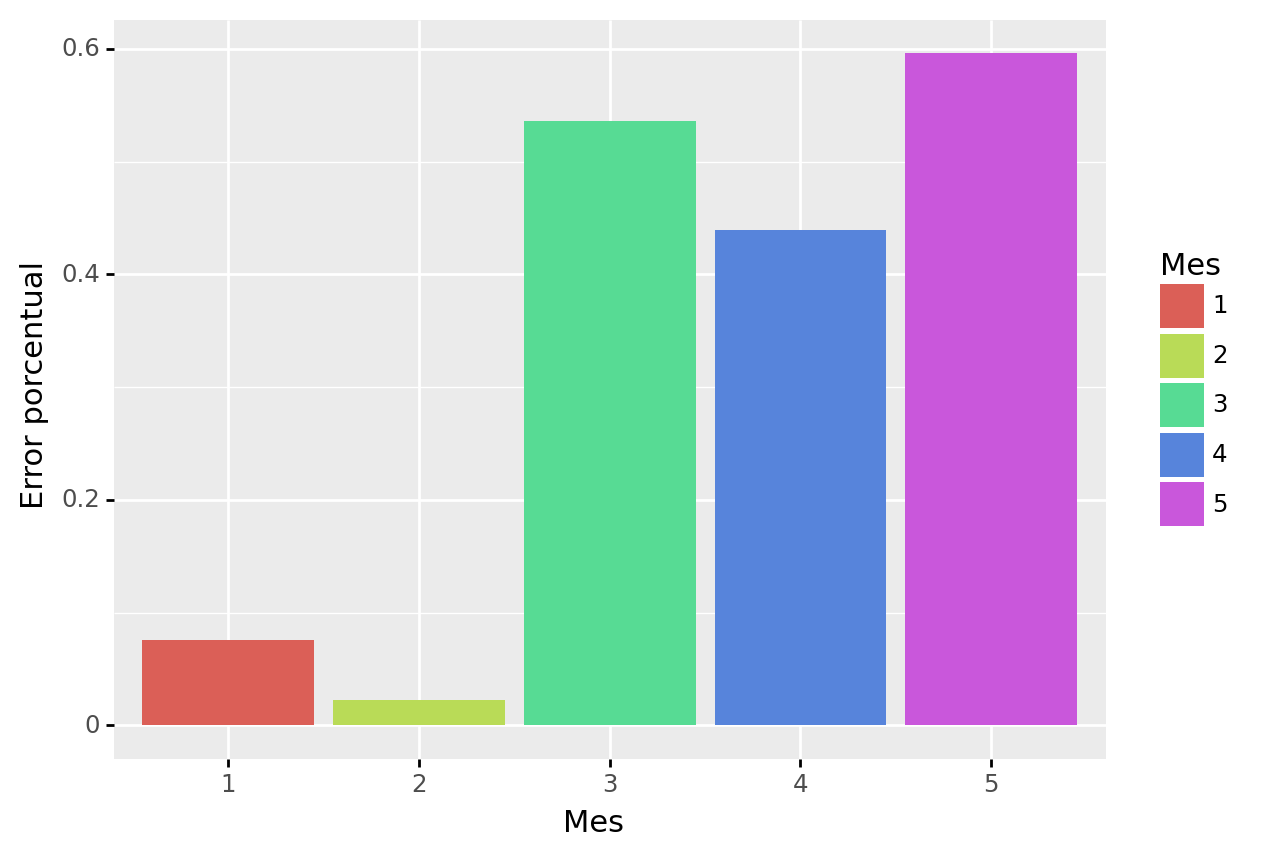

<ggplot: (166678145455)>

In [61]:
ggplot(dx, aes(x=dx.Mes,y='Error porcentual'))+\
geom_col(aes(fill='Mes'))

## Iteración Prophet simple

se busca realizar una prediccion recuerrente de los dias del 2021
para ello se tiene que predecir con el dia 2019 ... 2021-1-1 el dia 2021-1-2 e ir aumentando la data hasta llegar al  2021-2-11

### Sin iteración predicción con conocimiento perfeccto

In [62]:
df_P=DF_prophet[['Día natural', y_col]].copy()
df_P.columns = ['ds','y']

#FECHA DE INICIO
df_P=df_P[df_P.ds>=datetime.date(2019, 1, 1)]
df_P.head(1)
#print_simpl_graph(df_P)

,ds,y
485,2019-01-03,3516.219512


###  Particion

In [63]:
i=1
#FECHA DE TERMINO
df_P_train=df_P[df_P.ds<datetime.date(2021, i, 1)].copy()

#FECHA DE PRUEBA
df_P_test=df_P[df_P.ds>datetime.date(2021, i, 1)].copy()
df_P_test=df_P_test[df_P_test.ds<datetime.date(2021, i+1, 1)]

In [64]:
# convert dates from string to datetime
df_P_train.ds = pd.to_datetime(df_P_train.ds)
# convert dates from string to datetime
df_P_test.ds = pd.to_datetime(df_P_test.ds)
#print(df_P_test.dtypes,df_P_train.dtypes)

In [65]:
print('tail train:',df_P_train.tail(1).ds.iloc[0])
print('tail test:',df_P_test.tail(1).ds.iloc[0])

tail train: 2020-12-31 00:00:00
tail test: 2021-01-30 00:00:00


### función 

In [66]:
def Predict_Prophet(D_Train,D_Test,periodos):
    
    #D_propht:= Df utilizado para predecir
    # ds es date
    # y es la variable a predecir
    
    
    
    
    # column names for prophet compliance
    D_Train.columns = ['ds','y']
    #D_propht.head(3)
    
    # convert dates from string to datetime
    D_Train.ds = pd.to_datetime(D_Train.ds)
    print(D_Train.dtypes)
    
    #imprime la grafica de dispersión de los datos
    print_simpl_graph(D_Train)
    print_simpl_graph(D_Test)
    
    # set prophet model 
    prophet = Prophet(changepoint_prior_scale=0.15, yearly_seasonality=True)
    
    # fit $wmt data to model
    prophet.fit(D_Train)
    
    
    
    
    largo=D_Test.tail(1).ds.iloc[0]-D_Train.tail(1).ds.iloc[0]
    #prophet.make_future_dataframe(periods= abs(largo.days)+5 , freq='D').tail()
    print(D_Train.tail(1).ds.iloc[0])
    print(D_Test.tail(1).ds.iloc[0])
    print(largo)
    
    
    # build future dataframe for 5 years
    build_forecast = prophet.make_future_dataframe(periods= abs(largo.days) , freq='D')
    #prophet.make_future_dataframe(periods= periodos, freq='D')
    
    # forecast future df w/ model
    forecast = prophet.predict(build_forecast)
    
    
    

    #plot forecasts
    prophet.plot(forecast, xlabel='Date', ylabel= y_value)
    plt.plot(D_Test.ds, D_Test.y, color='red', marker='o', linestyle=':',markersize=4,)
    plt.title('Comportamiento '+ y_title)
    # display graph
    plt.show()

    
    # tell us more about the forecast
    prophet.plot_components(forecast)
    
    return(prophet,build_forecast,forecast)

ds    datetime64[ns]
y            float64
dtype: object


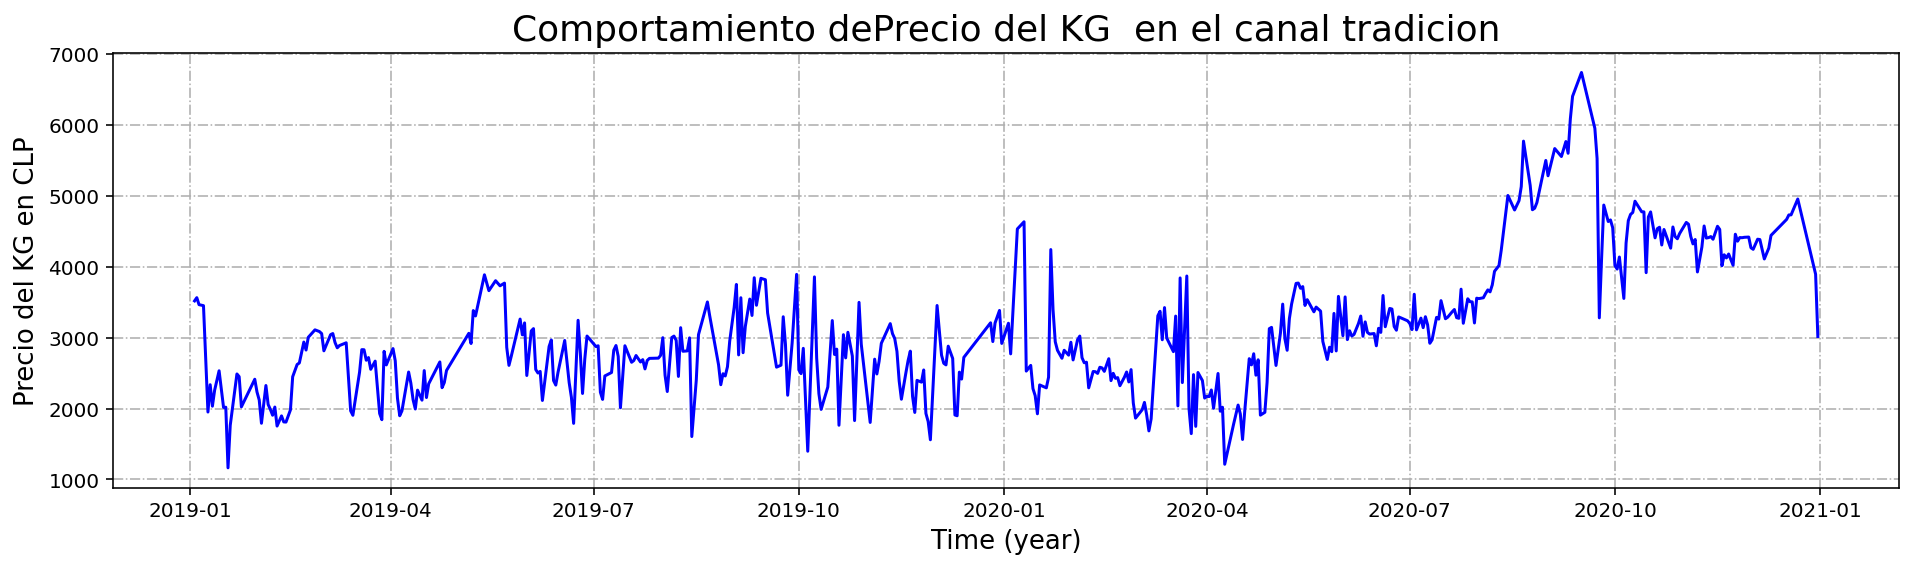

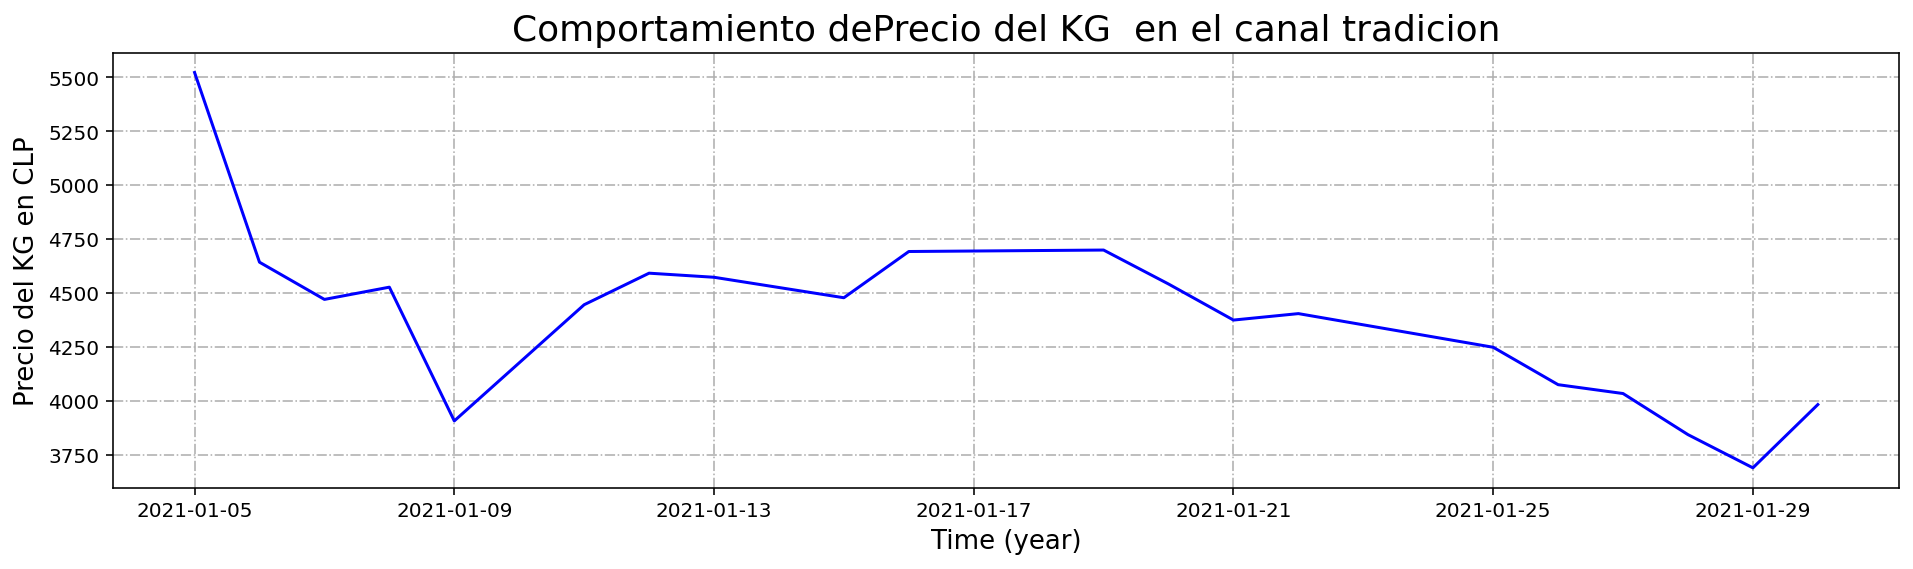

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2020-12-31 00:00:00
2021-01-30 00:00:00
30 days 00:00:00


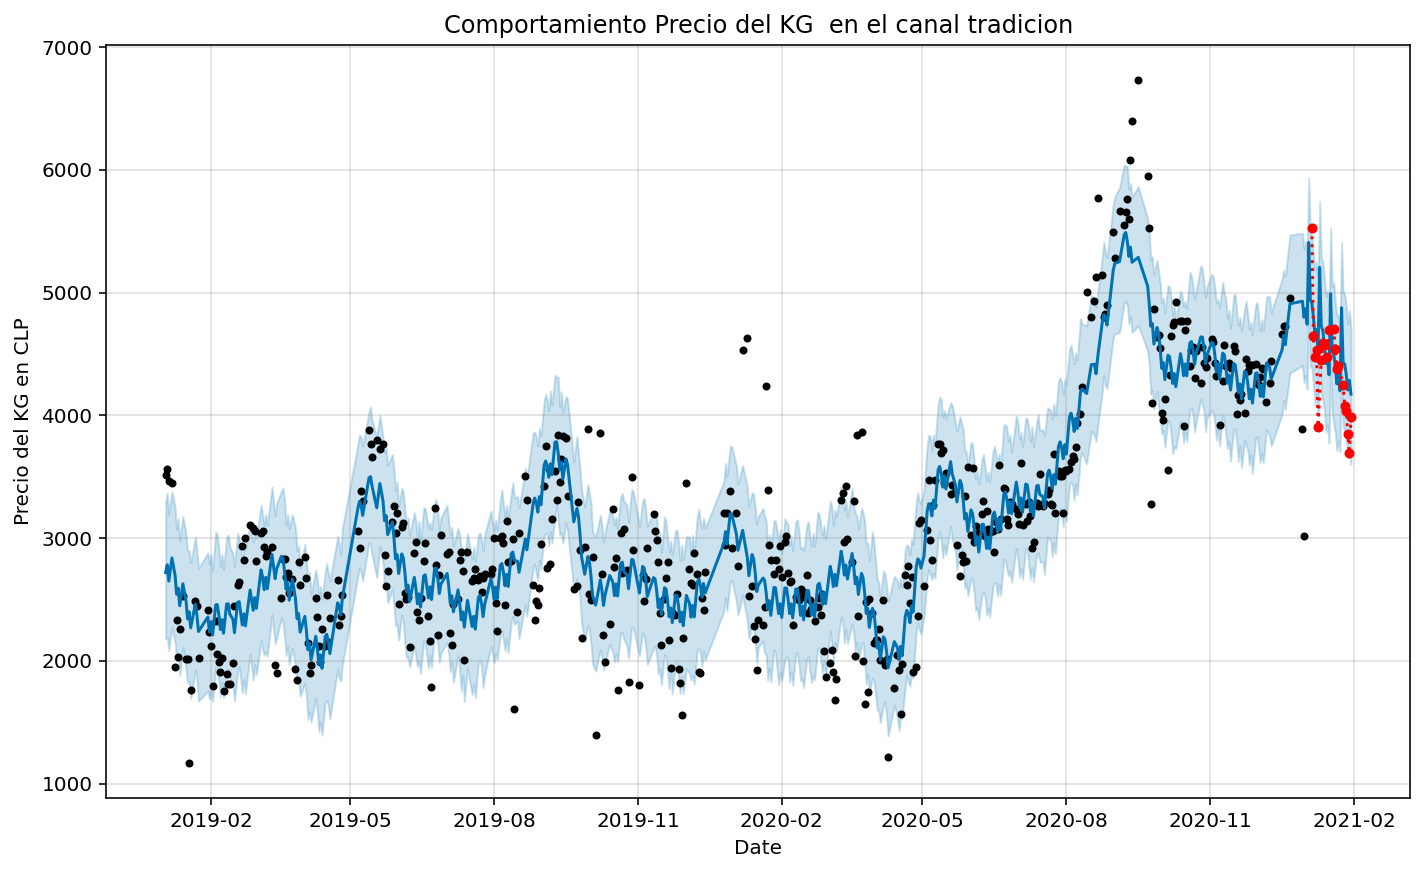

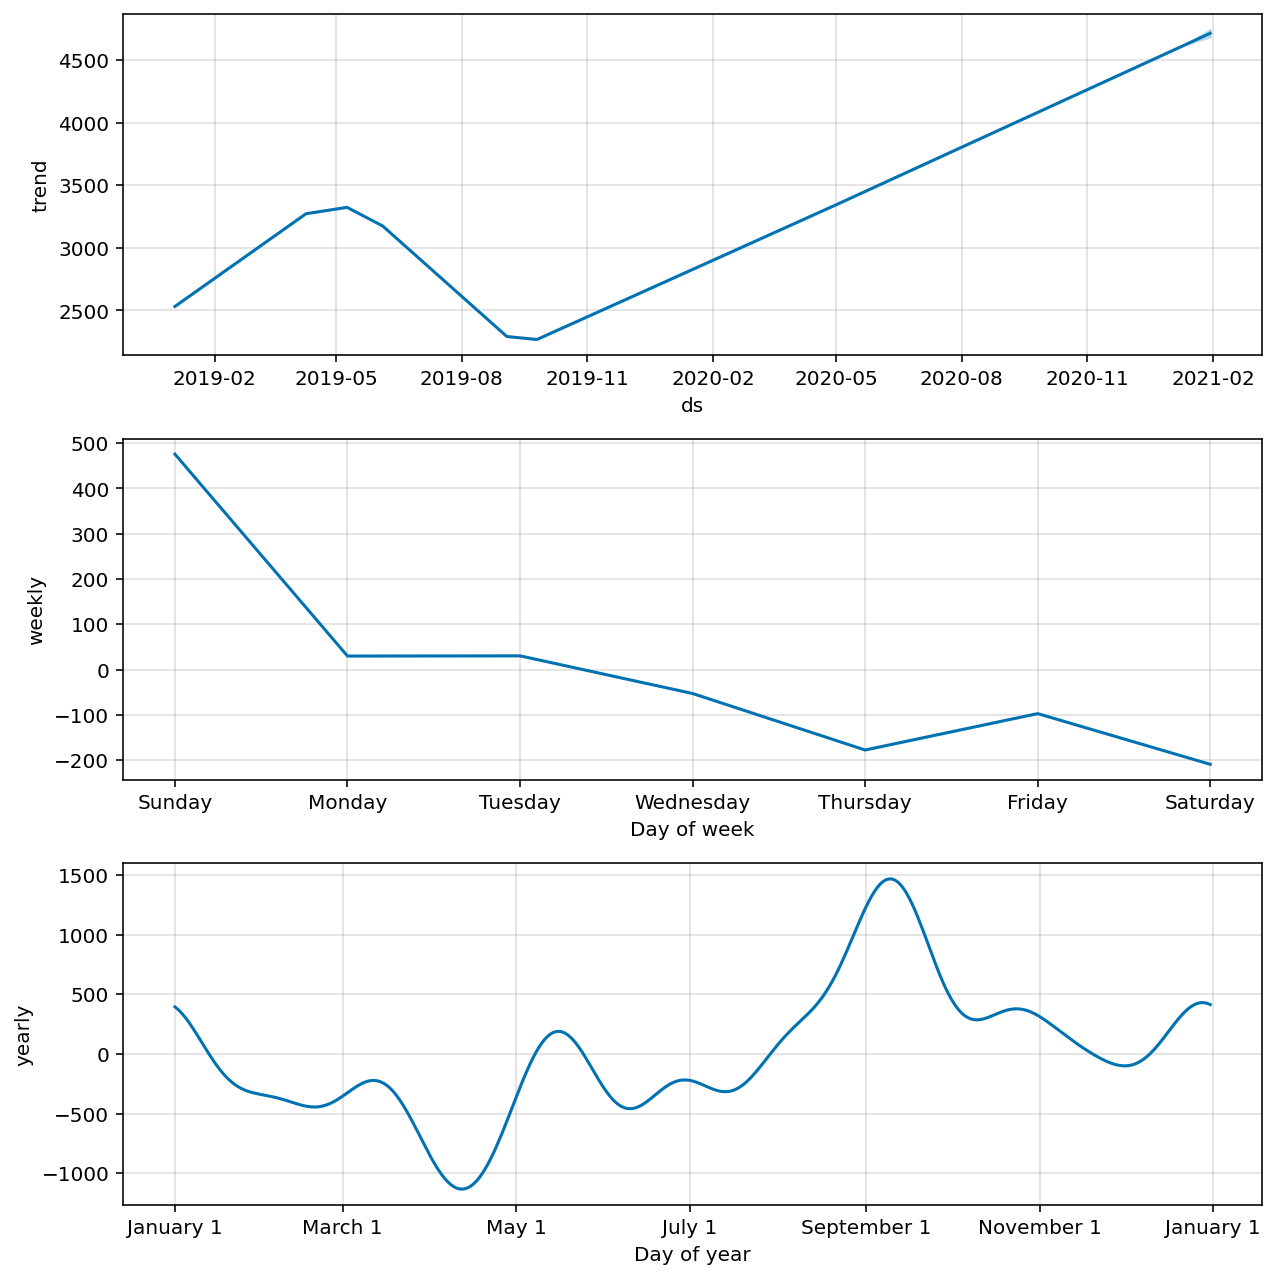

In [67]:
Resultados=Predict_Prophet(df_P_train,df_P_test,0)

In [68]:
DF_Predict=Resultados[2][['ds','yhat']]#.reset_index()
DF_Predict.head()

,ds,yhat
0,2019-01-03,2718.837762
1,2019-01-04,2781.651176
2,2019-01-05,2648.882086
3,2019-01-07,2838.055887
4,2019-01-09,2697.566159


### Error

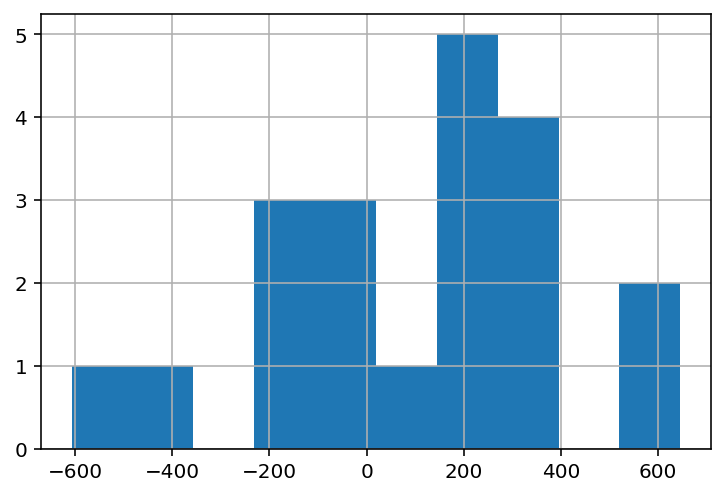

Error esperado 98.44622742225113
(4, 5)


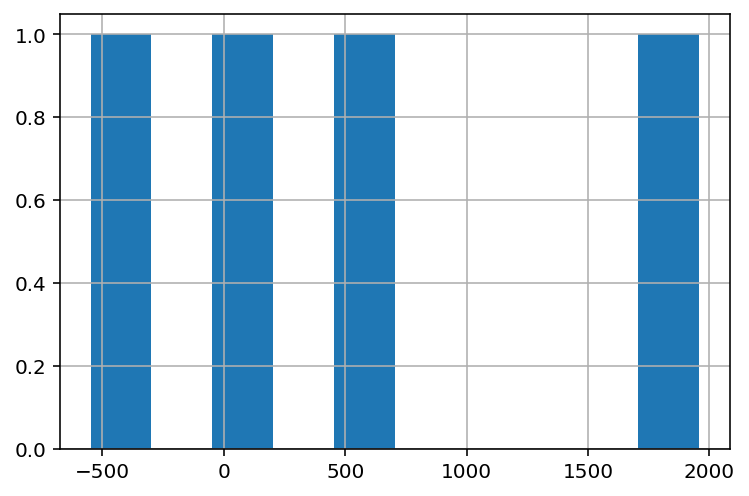

,Mes,Semana,y,yhat,Error
0,1,1,23073.095002,23622.046354,548.951353
1,1,2,22784.675259,22794.524545,9.849285
2,1,3,18022.843647,17474.470140,-548.373506
3,1,4,23878.027882,25836.525300,1958.497417


In [69]:
def Error_Pred(DF_Predict,df_P_test):
    DF_E=pd.merge(df_P_test,DF_Predict
                     , how='left')
    DF_E['Error']=DF_E['yhat']-DF_E.y

    
    DF_E.Error.hist()
    plt.show()
    tempo=DF_E.copy()
    tempo['Semana']=tempo.ds.apply(lambda x: x.week).astype('category')
    tempo['Mes']=tempo.ds.apply(lambda x: x.month).astype('category')
    tempo.Error=tempo.Error.astype('float64')#.abs()
    print('Error esperado',tempo.Error.sum()/tempo.shape[0])
    
    tmp=tempo.groupby(['Mes','Semana']).sum().reset_index()
    # como es categorico, generá valores 0 para las columnas 
    #que no tienen registros en el mes.
    #para evitar esto, se filtran los valores menos a 0.
    tmp=tmp[tmp.y > 0]
    print(tmp.shape)
    
    
    tmp.Error.hist()
    plt.show()
    
    
    return(tmp)




Error_Pred(DF_Predict,df_P_test)

In [70]:
tempo=dfx.copy()
tempo['Semana']=tempo.ds.apply(lambda x: x.week).astype('category')
tempo['Mes']=tempo.ds.apply(lambda x: x.month).astype('category')
tempo.Error=tempo.Error.astype('float64')#.abs()
tempo.Error.sum()/tempo.shape[0]

329.6049894530167

####  histograma del eroor por semana

(21, 5)


<AxesSubplot:>

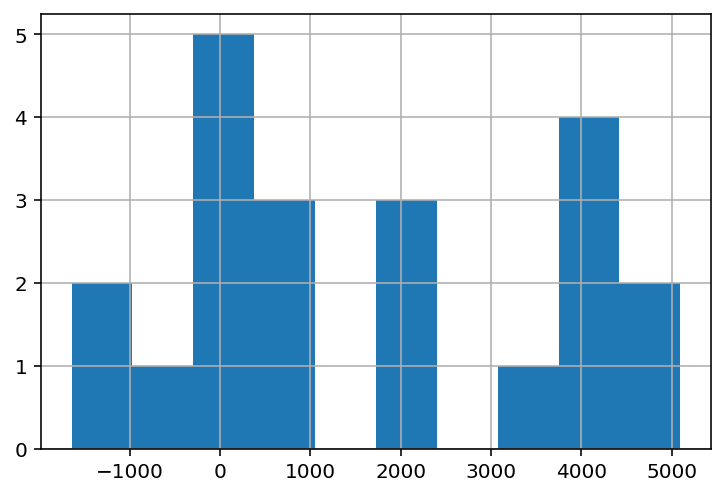

In [71]:
tmp=tempo.groupby(['Mes','Semana']).sum().reset_index()
# como es categorico, generá valores 0 para las columnas 
#que no tienen registros en el mes.
#para evitar esto, se filtran los valores menos a 0.
tmp=tmp[tmp.y > 0]
print(tmp.shape)
tmp.Error.hist()

In [72]:
tmp.head()

,Mes,Semana,yhat,y,Error
0,1,1,23622.046354,23073.095002,548.951353
1,1,2,22794.524545,22784.675259,9.849285
2,1,3,17474.470140,18022.843647,-548.373506
3,1,4,25836.525300,23878.027882,1958.497417
24,2,5,25820.862685,24810.477796,1010.384889


In [73]:
286.894011/637

0.4503830627943485

#### graffica anance del erro semana a semana 

## Iteración Prophet 

se busca realizar una prediccion recuerrente de los dias del 2021
para ello se tiene que predecir con el dia 2019 ... 2021-1-1 el dia 2021-1-2 e ir aumentando la data hasta llegar al  2021-2-11

### Sin iteración predicción con conocimiento perfeccto

In [74]:
df_P=DF_prophet[['Día natural', y_col]].copy()
df_P.columns = ['ds','y']

#FECHA DE INICIO
df_P=df_P[df_P.ds>=datetime.date(2019, 1, 1)]
df_P.head(1)
#print_simpl_graph(df_P)

,ds,y
485,2019-01-03,3516.219512


###  Particion

In [75]:
i=1
#FECHA DE TERMINO
df_P_train=df_P[df_P.ds<datetime.date(2021, i, 1)].copy()

#FECHA DE PRUEBA
df_P_test=df_P[df_P.ds>datetime.date(2021, i, 1)].copy()
df_P_test=df_P_test[df_P_test.ds<datetime.date(2021, i+1, 1)]
# convert dates from string to datetime
df_P_train.ds = pd.to_datetime(df_P_train.ds)
# convert dates from string to datetime
df_P_test.ds = pd.to_datetime(df_P_test.ds)
#print(df_P_test.dtypes,df_P_train.dtypes)

print('tail train:',df_P_train.tail(1).ds.iloc[0])
print('tail test:',df_P_test.tail(1).ds.iloc[0])

tail train: 2020-12-31 00:00:00
tail test: 2021-01-30 00:00:00


### funciónes

#### Predicción

In [76]:
def Predict_Prophet(D_Train,D_Test,periodos):
    
    #D_propht:= Df utilizado para predecir
    # ds es date
    # y es la variable a predecir
    
    
    
    
    # column names for prophet compliance
    D_Train.columns = ['ds','y']
    #D_propht.head(3)
    
    # convert dates from string to datetime
    D_Train.ds = pd.to_datetime(D_Train.ds)
    print(D_Train.dtypes)
    
    """
    #imprime la grafica de dispersión de los datos
    print_simpl_graph(D_Train)
    print_simpl_graph(D_Test)
    """
    # set prophet model 
    prophet = Prophet(changepoint_prior_scale=0.15, yearly_seasonality=True)
    
    # fit $wmt data to model
    prophet.fit(D_Train)
    
    
    
    
    largo=D_Test.tail(1).ds.iloc[0]-D_Train.tail(1).ds.iloc[0]
    #prophet.make_future_dataframe(periods= abs(largo.days)+5 , freq='D').tail()
    print(D_Train.tail(1).ds.iloc[0])
    print(D_Test.tail(1).ds.iloc[0])
    print(largo)
    
    
    # build future dataframe for 5 years
    build_forecast = prophet.make_future_dataframe(periods= abs(largo.days) , freq='D')
    #prophet.make_future_dataframe(periods= periodos, freq='D')
    
    # forecast future df w/ model
    forecast = prophet.predict(build_forecast)
    
    
    
    """
    #plot forecasts
    prophet.plot(forecast, xlabel='Date', ylabel= y_value)
    plt.plot(D_Test.ds, D_Test.y, color='red', marker='o', linestyle=':',markersize=4,)
    plt.title('Comportamiento '+ y_title)
    # display graph
    plt.show()

    
    # tell us more about the forecast
    prophet.plot_components(forecast)
    """
    return(prophet,build_forecast,forecast)

#### Error

In [77]:
def Error_Pred(DF_Predict,df_P_test):
    DF_E=pd.merge(df_P_test,DF_Predict
                     , how='left')
    DF_E['Error']=DF_E['yhat']-DF_E.y
    
    DF_E['Error %']=DF_E['yhat']/DF_E.y-1
    """
    DF_E.Error.hist()
    plt.show()
    """
    
    tempo=DF_E.copy()
    tempo['Semana']=tempo.ds.apply(lambda x: x.week).astype('category')
    tempo['Mes']=tempo.ds.apply(lambda x: x.month).astype('category')
    tempo.Error=tempo.Error.astype('float64')#.abs()
    print('Error esperado',tempo.Error.sum()/tempo.shape[0])
    
    tmp=tempo.groupby(['Mes','Semana']).mean().reset_index()
    # como es categorico, generá valores 0 para las columnas 
    #que no tienen registros en el mes.
    #para evitar esto, se filtran los valores menos a 0.
    
    
    tmp=tmp[tmp.y > 0]
    print(tmp.shape)
    
    """
    tmp.Error.hist()
    plt.show()
    """
    
    return(tempo)

### Predicciones siguientes 

In [78]:
Resultados=Predict_Prophet(df_P_train,df_P_test,0)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds    datetime64[ns]
y            float64
dtype: object
2020-12-31 00:00:00
2021-01-30 00:00:00
30 days 00:00:00


In [79]:
DF_Predict=Resultados[2][['ds','yhat']]#.reset_index()
DF_Predict.head()

,ds,yhat
0,2019-01-03,2718.837762
1,2019-01-04,2781.651176
2,2019-01-05,2648.882086
3,2019-01-07,2838.055887
4,2019-01-09,2697.566159


In [80]:
Error_DF_Sum=Error_Pred(DF_Predict,df_P_test)
Error_DF_Sum

Error esperado 98.44622742225113
(4, 6)


,ds,y,yhat,Error,Error %,Semana,Mes
0,2021-01-05,5522.940476,4915.458823,-607.481653,-0.109992,1,1
1,2021-01-06,4643.523077,4804.574773,161.051696,0.034683,1,1
2,2021-01-07,4471.044643,4649.842147,178.797504,0.039990,1,1
3,2021-01-08,4527.781250,4698.500514,170.719264,0.037705,1,1
4,2021-01-09,3907.805556,4553.670097,645.864541,0.165276,1,1
5,2021-01-11,4446.426752,4725.366702,278.939950,0.062734,2,1
6,2021-01-12,4592.661157,4692.278487,99.617330,0.021691,2,1
7,2021-01-13,4573.692308,4576.381444,2.689136,0.000588,2,1
8,2021-01-15,4478.781250,4470.307346,-8.473904,-0.001892,2,1
9,2021-01-16,4693.113793,4330.190567,-362.923226,-0.077331,2,1


#### iteracion demas meses 

In [81]:
for i in range(2,6):
    print('\n',i)
    #FECHA DE TERMINO
    df_P_train=df_P[df_P.ds<datetime.date(2021, i, 1)].copy()

    #FECHA DE PRUEBA
    df_P_test=df_P[df_P.ds>datetime.date(2021, i, 1)].copy()
    df_P_test=df_P_test[df_P_test.ds<datetime.date(2021, i+1, 1)]
    # convert dates from string to datetime
    df_P_train.ds = pd.to_datetime(df_P_train.ds)
    # convert dates from string to datetime
    df_P_test.ds = pd.to_datetime(df_P_test.ds)
    #print(df_P_test.dtypes,df_P_train.dtypes)

    print('tail train:',df_P_train.tail(1).ds.iloc[0])
    print('tail test:',df_P_test.tail(1).ds.iloc[0])
    
    Resultados=Predict_Prophet(df_P_train,df_P_test,0)
    DF_Predict=Resultados[2][['ds','yhat']]#.reset_index()
    di=Error_Pred(DF_Predict,df_P_test)
    Error_DF_Sum=pd.concat([Error_DF_Sum, di])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



 2
tail train: 2021-01-30 00:00:00
tail test: 2021-02-27 00:00:00
ds    datetime64[ns]
y            float64
dtype: object
2021-01-30 00:00:00
2021-02-27 00:00:00
28 days 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Error esperado -93.62576439143132
(4, 6)

 3
tail train: 2021-02-27 00:00:00
tail test: 2021-03-31 00:00:00
ds    datetime64[ns]
y            float64
dtype: object
2021-02-27 00:00:00
2021-03-31 00:00:00
32 days 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Error esperado 388.40597489824154
(5, 6)

 4
tail train: 2021-03-31 00:00:00
tail test: 2021-04-30 00:00:00
ds    datetime64[ns]
y            float64
dtype: object
2021-03-31 00:00:00
2021-04-30 00:00:00
30 days 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Error esperado 44.78723997984835
(4, 6)

 5
tail train: 2021-04-30 00:00:00
tail test: 2021-05-20 00:00:00
ds    datetime64[ns]
y            float64
dtype: object
2021-04-30 00:00:00
2021-05-20 00:00:00
20 days 00:00:00
Error esperado 181.54716792005013
(3, 6)


In [82]:
Error_DF_Sum.Mes=Error_DF_Sum.Mes.astype('category')

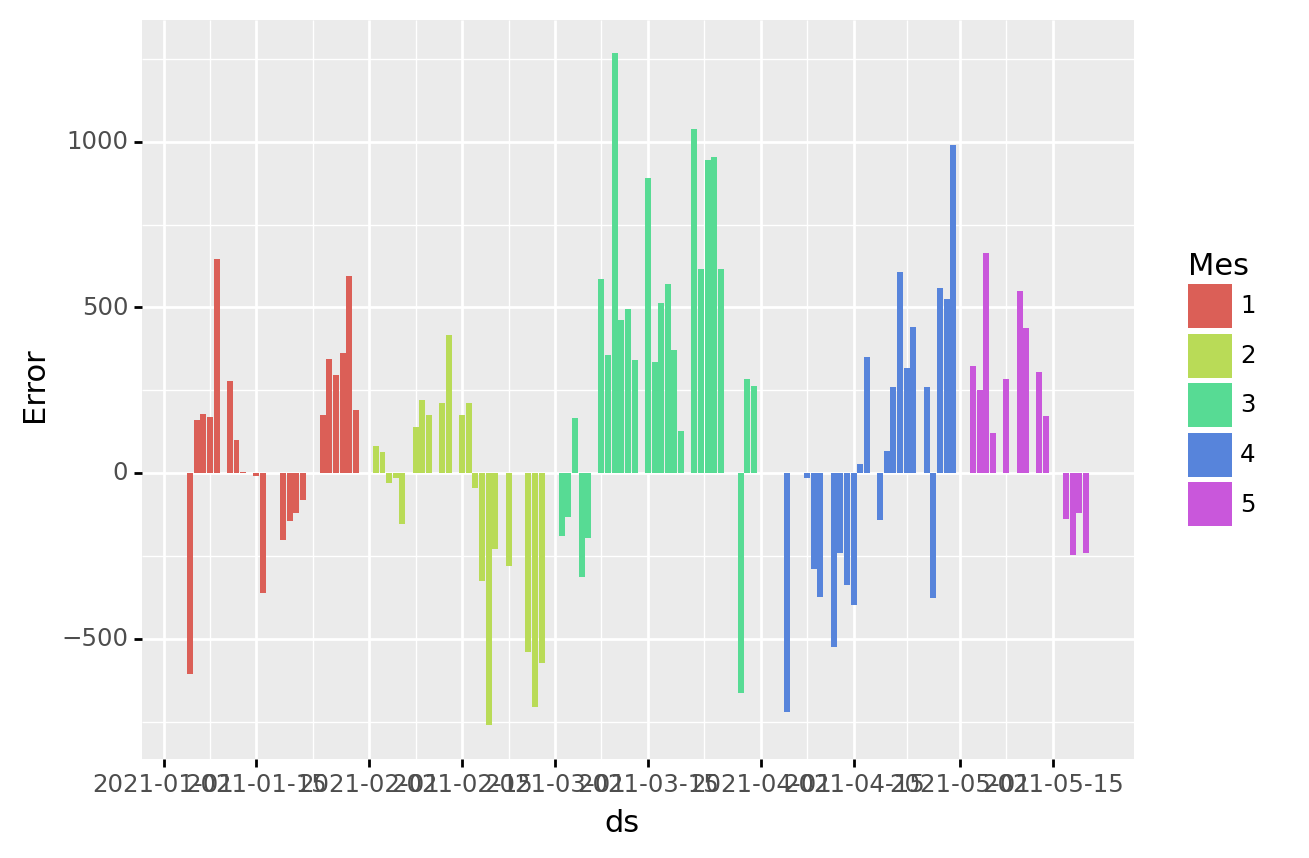

<ggplot: (166682817606)>

In [83]:
ggplot(Error_DF_Sum, aes(x=Error_DF_Sum.ds,y='Error'))+\
geom_col(aes(fill='Mes'))

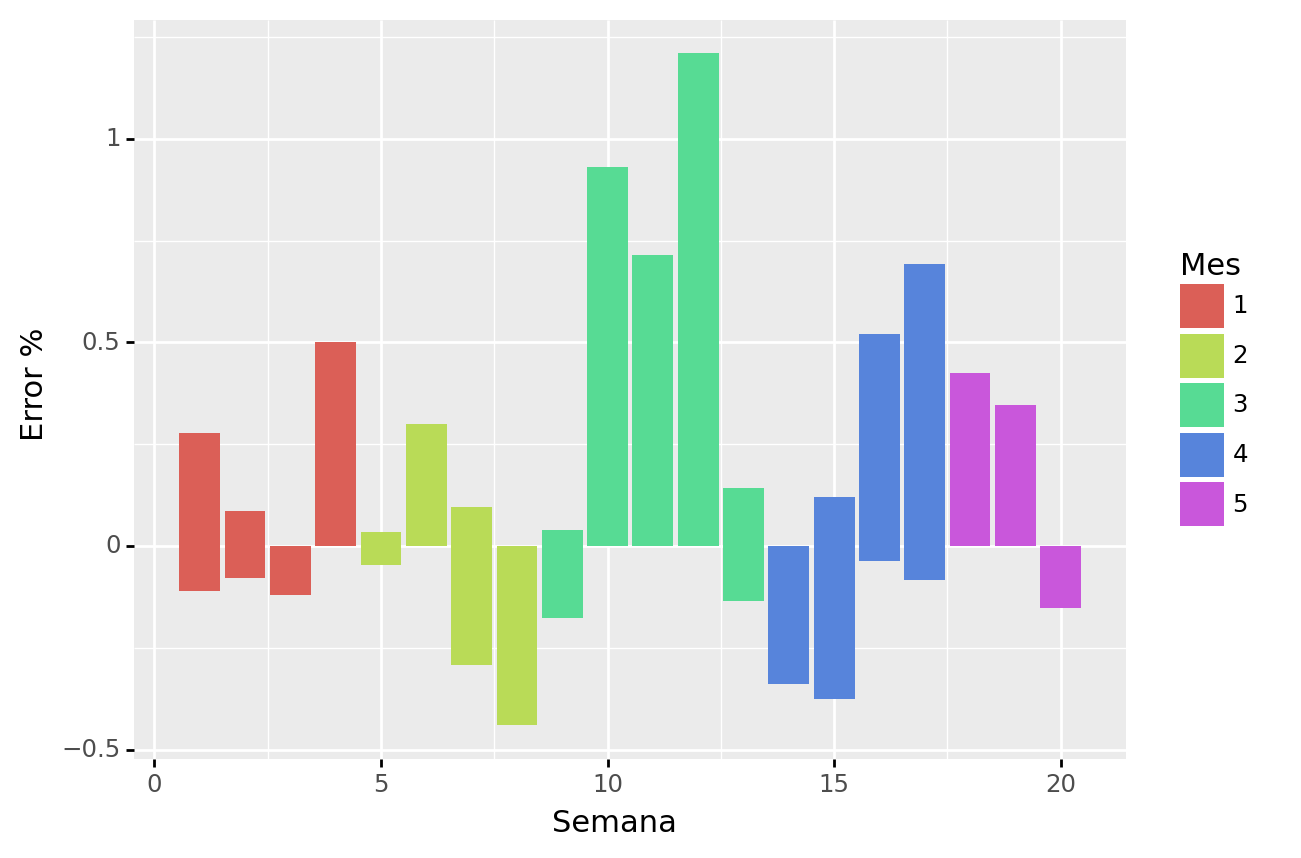

<ggplot: (166677146474)>

In [84]:
ggplot(Error_DF_Sum, aes(x=Error_DF_Sum.Semana,y='Error %'))+\
geom_col(aes(fill='Mes'))

In [85]:
Error_DF_Sum

,ds,y,yhat,Error,Error %,Semana,Mes
0,2021-01-05,5522.940476,4915.458823,-607.481653,-0.109992,1,1
1,2021-01-06,4643.523077,4804.574773,161.051696,0.034683,1,1
2,2021-01-07,4471.044643,4649.842147,178.797504,0.039990,1,1
3,2021-01-08,4527.781250,4698.500514,170.719264,0.037705,1,1
4,2021-01-09,3907.805556,4553.670097,645.864541,0.165276,1,1
...,...,...,...,...,...,...,...
8,2021-05-14,4489.125000,4660.814178,171.689178,0.038246,19,5
9,2021-05-17,4946.311475,4807.829703,-138.481773,-0.027997,20,5
10,2021-05-18,5049.000000,4800.930761,-248.069239,-0.049132,20,5
11,2021-05-19,4793.349754,4673.131282,-120.218472,-0.025080,20,5


In [86]:
Error_DF_Sum.Error.describe()

count     101.000000
mean      129.290746
std       410.418585
min      -761.648031
25%      -145.532688
50%       170.719264
75%       357.578527
max      1266.588275
Name: Error, dtype: float64

In [87]:
Error_DF_Sum['Error porcentual']=Error_DF_Sum.yhat/Error_DF_Sum.y-1
Error_DF_Sum['Error porcentual'].describe()
Error_DF_Sum.pop('Error porcentual')

0    -0.109992
1     0.034683
2     0.039990
3     0.037705
4     0.165276
        ...   
8     0.038246
9    -0.027997
10   -0.049132
11   -0.025080
12   -0.050413
Name: Error porcentual, Length: 101, dtype: float64

#### group mensual 

In [88]:
tmp2=Error_DF_Sum.copy()
tmp2.Error=tmp2.Error.astype('float64')#.abs()
tmp2.Mes=tmp2.Mes.astype('category')

print(tmp2.Error.mean())

dx=tmp2.groupby('Mes').sum().reset_index()#['Mes','Error']
dx

129.2907458534487


,Mes,y,yhat,Error,Error %,Semana
0,1,87758.641790,89727.566338,1968.924548,0.553802,51
1,2,89653.010787,87686.869735,-1966.141052,-0.351502,135
2,3,101117.278267,110827.427639,9710.149372,2.723364,270
3,4,80937.445148,81922.764427,985.319280,0.496351,341
4,5,56588.379296,58948.492479,2360.113183,0.618063,246


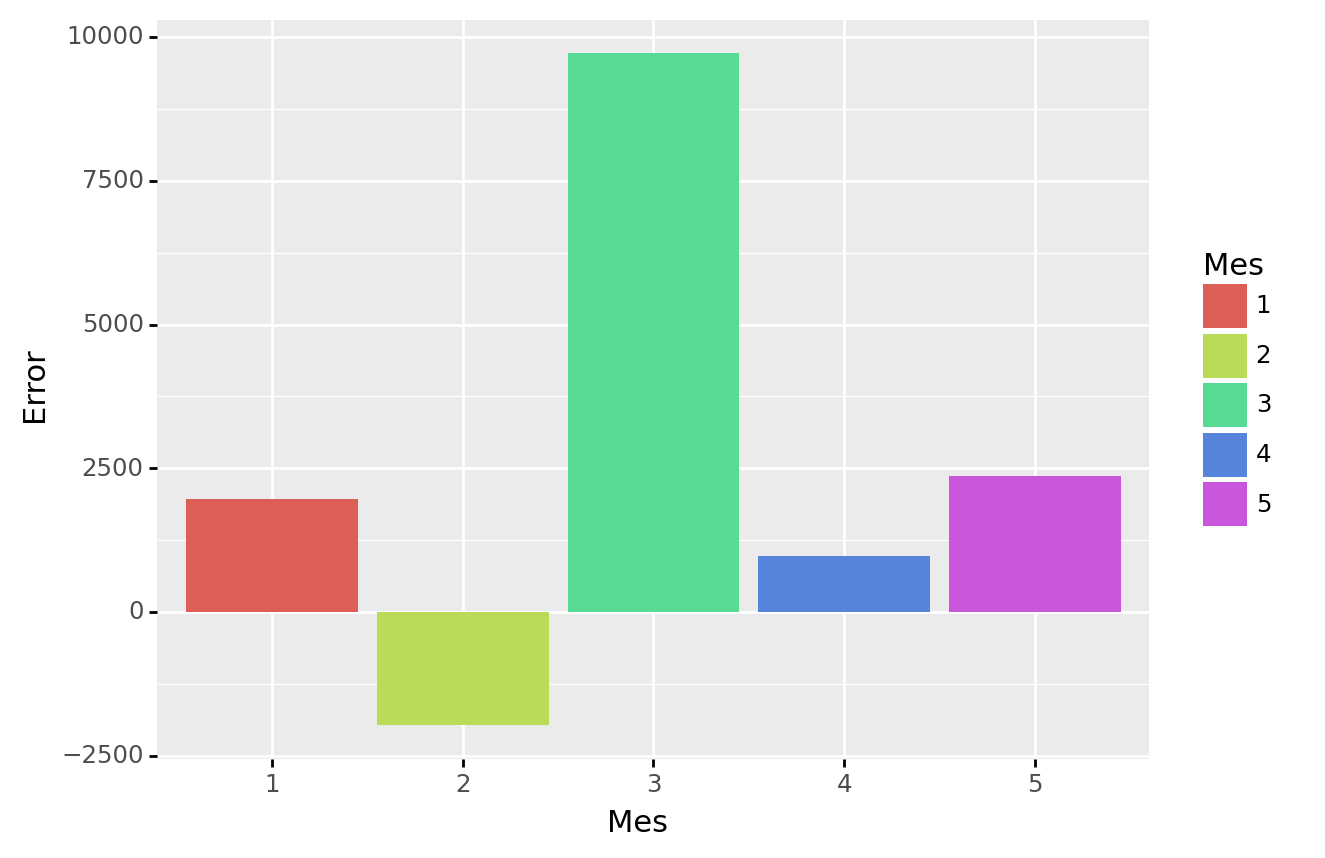

<ggplot: (166677155344)>

In [89]:
ggplot(dx, aes(x=dx.Mes,y='Error'))+\
geom_col(aes(fill='Mes'))

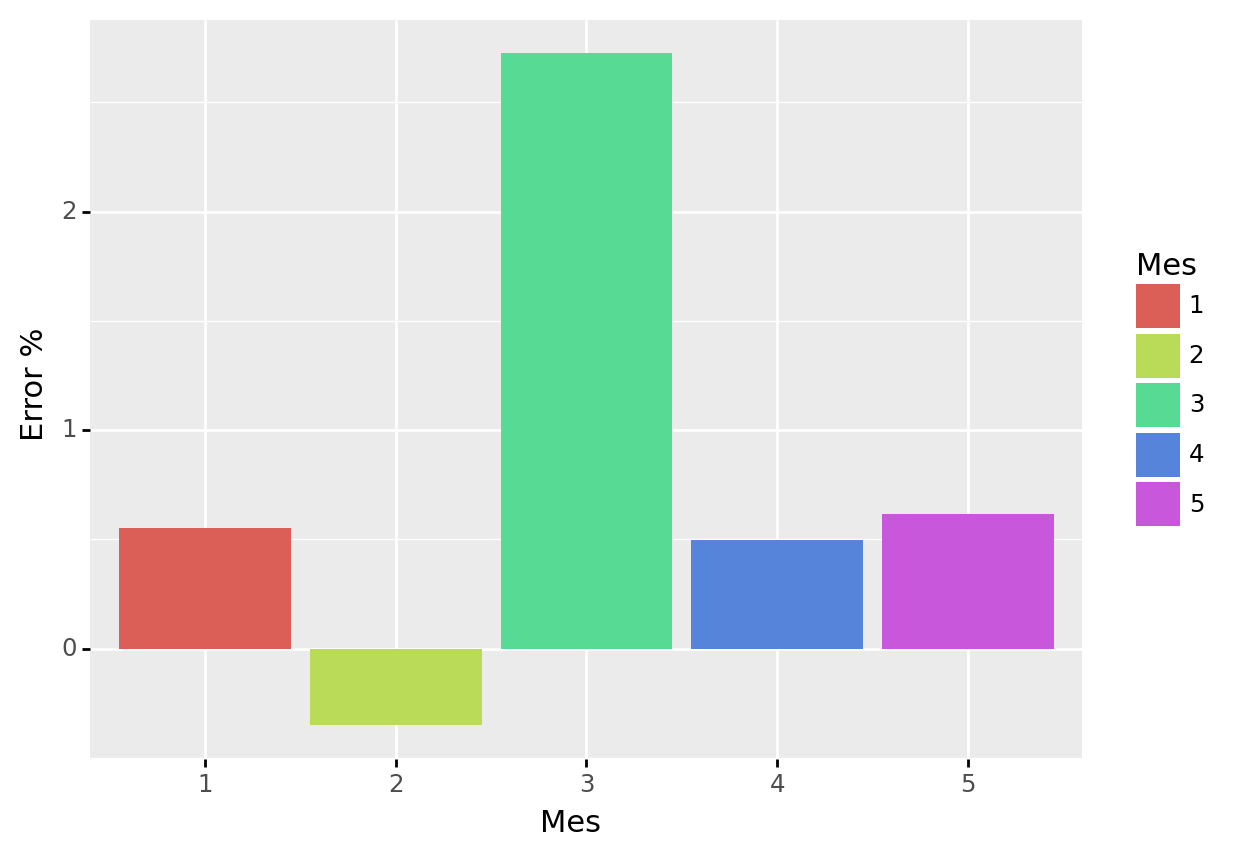

<ggplot: (166680892998)>

In [90]:
ggplot(dx, aes(x=dx.Mes,y='Error %'))+\
geom_col(aes(fill='Mes'))

# csv error iteracion

###  Particion

In [91]:
i=1
#FECHA DE TERMINO
df_P_train=df_P[df_P.ds<datetime.date(2021, i, 1)].copy()

#FECHA DE PRUEBA
df_P_test=df_P[df_P.ds>datetime.date(2021, i, 1)].copy()
df_P_test=df_P_test[df_P_test.ds<datetime.date(2021, i+1, 1)]
# convert dates from string to datetime
df_P_train.ds = pd.to_datetime(df_P_train.ds)
# convert dates from string to datetime
df_P_test.ds = pd.to_datetime(df_P_test.ds)
#print(df_P_test.dtypes,df_P_train.dtypes)

print('tail train:',df_P_train.tail(1).ds.iloc[0])
print('tail test:',df_P_test.tail(1).ds.iloc[0])

tail train: 2020-12-31 00:00:00
tail test: 2021-01-30 00:00:00


### funciónes

#### Predicción

In [92]:
def Predict_Prophet(D_Train,D_Test,periodos):
    
    #D_propht:= Df utilizado para predecir
    # ds es date
    # y es la variable a predecir
    
    
    
    
    # column names for prophet compliance
    D_Train.columns = ['ds','y']
    #D_propht.head(3)
    
    # convert dates from string to datetime
    D_Train.ds = pd.to_datetime(D_Train.ds)
    print(D_Train.dtypes)
    
    """
    #imprime la grafica de dispersión de los datos
    print_simpl_graph(D_Train)
    print_simpl_graph(D_Test)
    """
    # set prophet model 
    prophet = Prophet(changepoint_prior_scale=0.15, yearly_seasonality=True)
    
    # fit $wmt data to model
    prophet.fit(D_Train)
    
    
    
    
    largo=D_Test.tail(1).ds.iloc[0]-D_Train.tail(1).ds.iloc[0]
    #prophet.make_future_dataframe(periods= abs(largo.days)+5 , freq='D').tail()
    print(D_Train.tail(1).ds.iloc[0])
    print(D_Test.tail(1).ds.iloc[0])
    print(largo)
    
    
    # build future dataframe for 5 years
    build_forecast = prophet.make_future_dataframe(periods= abs(largo.days) , freq='D')
    #prophet.make_future_dataframe(periods= periodos, freq='D')
    
    # forecast future df w/ model
    forecast = prophet.predict(build_forecast)
    
    
    
    """
    #plot forecasts
    prophet.plot(forecast, xlabel='Date', ylabel= y_value)
    plt.plot(D_Test.ds, D_Test.y, color='red', marker='o', linestyle=':',markersize=4,)
    plt.title('Comportamiento '+ y_title)
    # display graph
    plt.show()

    
    # tell us more about the forecast
    prophet.plot_components(forecast)
    """
    return(prophet,build_forecast,forecast)

#### Error

In [93]:
def Error_Pred(DF_Predict,df_P_test):
    DF_E=pd.merge(df_P_test,DF_Predict
                     , how='left')
    DF_E['Error']=DF_E['yhat']-DF_E.y
    
    DF_E['Error %']=DF_E['yhat']/DF_E.y-1
    """
    DF_E.Error.hist()
    plt.show()
    """
    
    tempo=DF_E.copy()
    tempo['Semana']=tempo.ds.apply(lambda x: x.week).astype('category')
    tempo['Mes']=tempo.ds.apply(lambda x: x.month).astype('category')
    tempo.Error=tempo.Error.astype('float64')#.abs()
    print('Error esperado',tempo.Error.sum()/tempo.shape[0])
    
    tmp=tempo.groupby(['Mes','Semana']).mean().reset_index()
    # como es categorico, generá valores 0 para las columnas 
    #que no tienen registros en el mes.
    #para evitar esto, se filtran los valores menos a 0.
    
    
    tmp=tmp[tmp.y > 0]
    print(tmp.shape)
    
    """
    tmp.Error.hist()
    plt.show()
    """
    
    return(tempo)

### Predicciones siguientes 

In [94]:
Resultados=Predict_Prophet(df_P_train,df_P_test,0)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds    datetime64[ns]
y            float64
dtype: object
2020-12-31 00:00:00
2021-01-30 00:00:00
30 days 00:00:00


In [95]:
DF_Predict=Resultados[2][['ds','yhat']]#.reset_index()
DF_Predict.head()

,ds,yhat
0,2019-01-03,2718.837762
1,2019-01-04,2781.651176
2,2019-01-05,2648.882086
3,2019-01-07,2838.055887
4,2019-01-09,2697.566159


In [96]:
Error_DF_Sum=Error_Pred(DF_Predict,df_P_test)
Error_DF_Sum

Error esperado 98.44622742225113
(4, 6)


,ds,y,yhat,Error,Error %,Semana,Mes
0,2021-01-05,5522.940476,4915.458823,-607.481653,-0.109992,1,1
1,2021-01-06,4643.523077,4804.574773,161.051696,0.034683,1,1
2,2021-01-07,4471.044643,4649.842147,178.797504,0.039990,1,1
3,2021-01-08,4527.781250,4698.500514,170.719264,0.037705,1,1
4,2021-01-09,3907.805556,4553.670097,645.864541,0.165276,1,1
5,2021-01-11,4446.426752,4725.366702,278.939950,0.062734,2,1
6,2021-01-12,4592.661157,4692.278487,99.617330,0.021691,2,1
7,2021-01-13,4573.692308,4576.381444,2.689136,0.000588,2,1
8,2021-01-15,4478.781250,4470.307346,-8.473904,-0.001892,2,1
9,2021-01-16,4693.113793,4330.190567,-362.923226,-0.077331,2,1


#### iteracion demas meses 

In [97]:
for i in range(2,6):
    print('\n',i)
    #FECHA DE TERMINO
    df_P_train=df_P[df_P.ds<datetime.date(2021, i, 1)].copy()

    #FECHA DE PRUEBA
    df_P_test=df_P[df_P.ds>datetime.date(2021, i, 1)].copy()
    df_P_test=df_P_test[df_P_test.ds<datetime.date(2021, i+1, 1)]
    # convert dates from string to datetime
    df_P_train.ds = pd.to_datetime(df_P_train.ds)
    # convert dates from string to datetime
    df_P_test.ds = pd.to_datetime(df_P_test.ds)
    #print(df_P_test.dtypes,df_P_train.dtypes)

    print('tail train:',df_P_train.tail(1).ds.iloc[0])
    print('tail test:',df_P_test.tail(1).ds.iloc[0])
    
    Resultados=Predict_Prophet(df_P_train,df_P_test,0)
    DF_Predict=Resultados[2][['ds','yhat']]#.reset_index()
    di=Error_Pred(DF_Predict,df_P_test)
    Error_DF_Sum=pd.concat([Error_DF_Sum, di])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



 2
tail train: 2021-01-30 00:00:00
tail test: 2021-02-27 00:00:00
ds    datetime64[ns]
y            float64
dtype: object
2021-01-30 00:00:00
2021-02-27 00:00:00
28 days 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Error esperado -93.62576439143132
(4, 6)

 3
tail train: 2021-02-27 00:00:00
tail test: 2021-03-31 00:00:00
ds    datetime64[ns]
y            float64
dtype: object
2021-02-27 00:00:00
2021-03-31 00:00:00
32 days 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Error esperado 388.40597489824154
(5, 6)

 4
tail train: 2021-03-31 00:00:00
tail test: 2021-04-30 00:00:00
ds    datetime64[ns]
y            float64
dtype: object
2021-03-31 00:00:00
2021-04-30 00:00:00
30 days 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Error esperado 44.78723997984835
(4, 6)

 5
tail train: 2021-04-30 00:00:00
tail test: 2021-05-20 00:00:00
ds    datetime64[ns]
y            float64
dtype: object
2021-04-30 00:00:00
2021-05-20 00:00:00
20 days 00:00:00
Error esperado 181.54716792005013
(3, 6)


In [98]:
Error_DF_Sum.Mes=Error_DF_Sum.Mes.astype('category')

In [99]:
Error_DF_Sum.to_csv('E_interv_Prec.csv', index=False)